# Исследование объявлений о продаже квартир. 

По данным с сервиса Яндекс Недвижимость в Санкт-Петербурге нужно проанализировать данные об объектах недвижимости, найти зависимости, сделать выводы, установить факторы, которые больше всего  влияют на цену объекта. По каждой квартире на продажу доступны два вида данных: те что указали пользователи и те что получены из картографических сервисов. Нужно провести анализ данных, установить факторы, которые больше всего влияют на цену объектов. 

## Описание данных
Данные находятся в файле: https://code.s3.yandex.net/datasets/real_estate_data.csv

Список параметров:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего парка

## Загрузка данных

In [1]:
# Устанавливаем необходимые библиотеки
! pip install -q phik

In [2]:
# Игнорирование предупреждений системы
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Импорт необходимых билиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
# Настройка отображения
# Отображаем все столбцы и до 100 строк
pd.options.display.max_columns = 250
pd.options.display.max_rows = 100
#pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:20.2f}'.format

RANDOM_STATE = 42
TEST_SIZE = 0.25

Загрузим данные. Посмотрим формат.

In [5]:
# загрузка
df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t', parse_dates=['first_day_exposition'])
# Знакомство с данными
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00,108.00,2019-03-07,3,2.70,16.00,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,NaN
1,7,3350000.00,40.40,2018-12-04,1,NaN,11.00,18.60,1,NaN,False,False,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,NaN,0.00,NaN,81.00
2,10,5196000.00,56.00,2015-08-20,2,NaN,5.00,34.30,4,NaN,False,False,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00
3,0,64900000.00,159.00,2015-07-24,3,NaN,14.00,NaN,9,NaN,False,False,NaN,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00
4,2,10000000.00,100.00,2018-06-19,2,3.03,14.00,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

## Исследование данных

Посмотрим на характер распределения признаков.

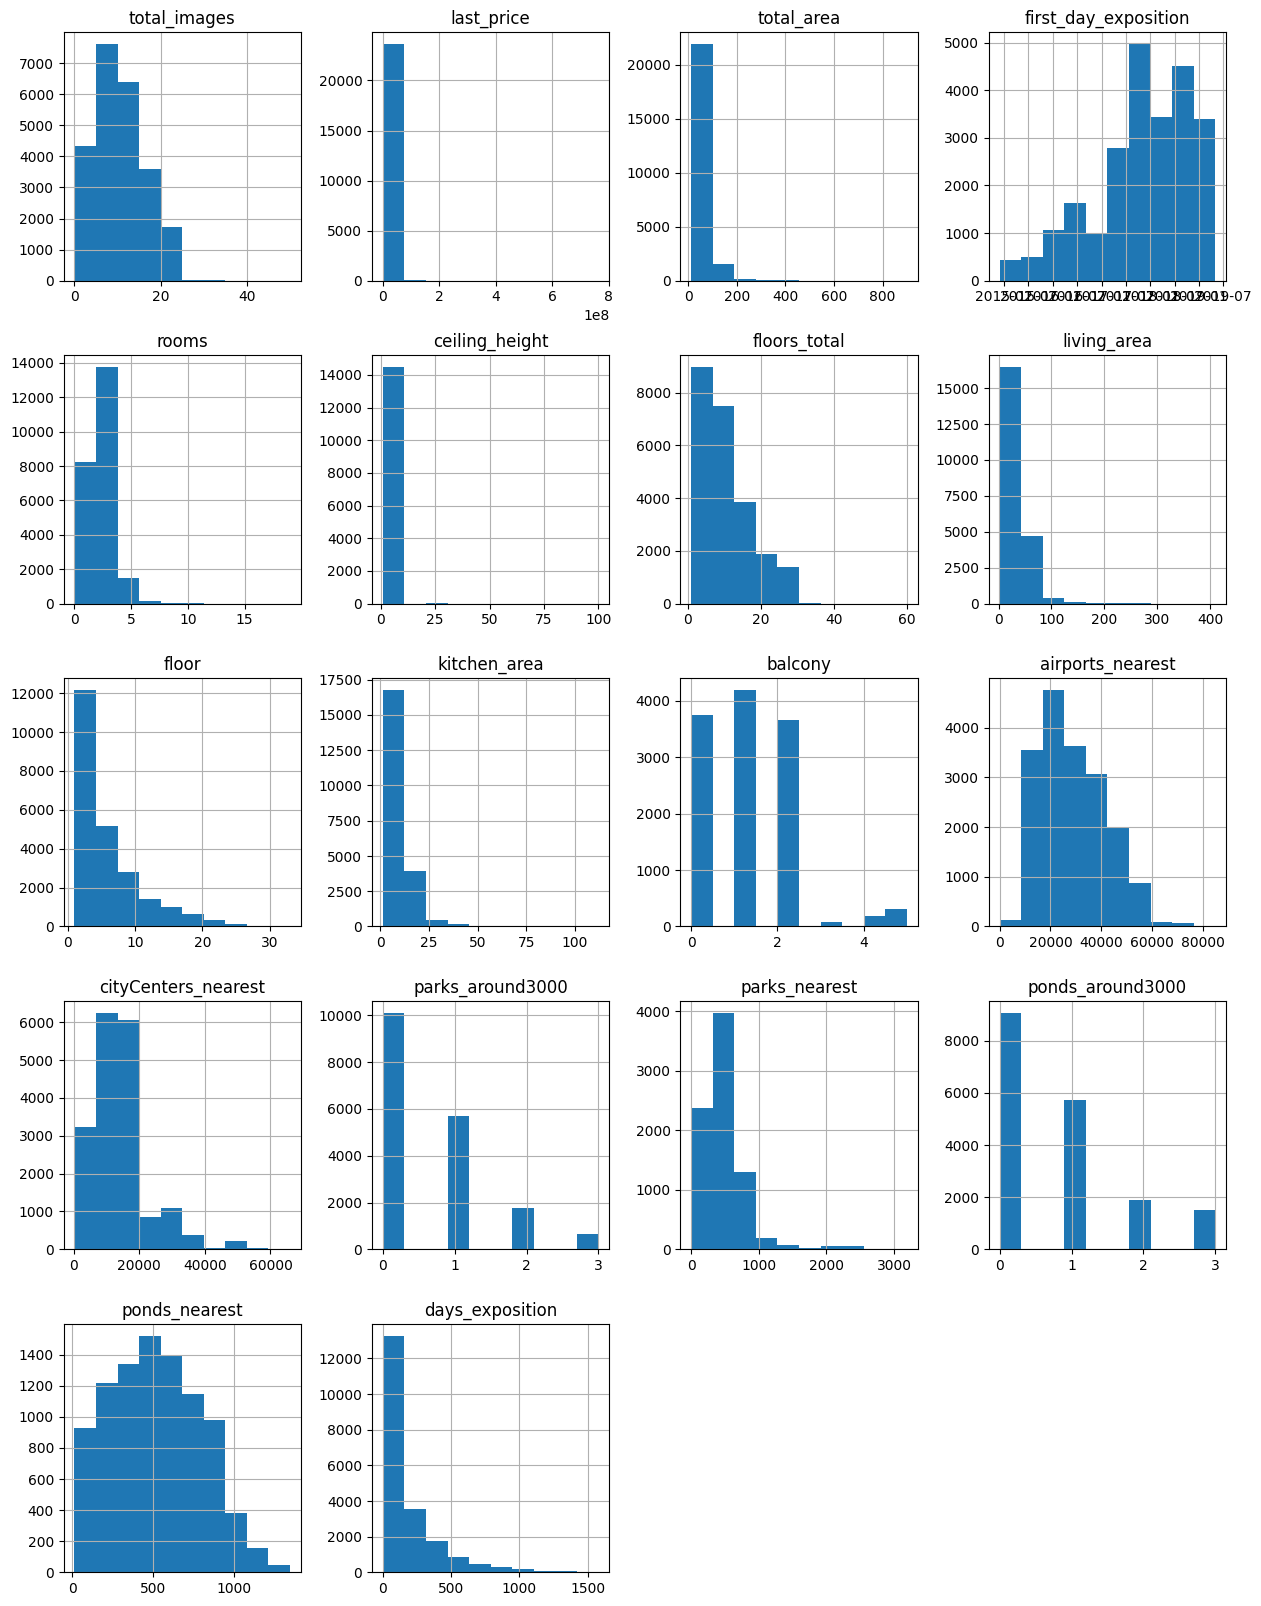

In [7]:
df.hist(figsize=(15, 20));

Для удобства применим функцию, котороая показывает параметры датафрейма.

In [8]:
def descr(df):
    '''
    Функция принимает датафрейм и выдает таблицу ключевых значений 
    по числовым и категориальным столбцам в компактном виде.
    '''
    df_describe = pd.DataFrame()
    for col in df.columns: 
        if df[col].dtypes in df.select_dtypes(include='number').dtypes.unique():
            df_describe[col] = [
                df[col].dtypes,
                df[col].isna().count(),
                df[col].count(),
                df[col].isna().sum(), 
                round(100*df[col].isna().sum()/df[col].isna().count(), 2),
                df[col].nunique(),
                df[col].min(),
                df[col].max(),
                df[col].duplicated().sum(),
                df[col].sort_values().unique()
            ]
        else:
            df_describe[col] = [
            df[col].dtypes,
            df[col].isna().count(),
            df[col].count(),
            df[col].isna().sum(), 
            round(100*df[col].isna().sum()/df[col].isna().count(), 2),
            df[col].nunique(),
            '-', 
            '-',
            df[col].duplicated().sum(),
            df[col].sort_values().unique()
        ]

    df_describe = df_describe.T
    df_describe.columns = ['Тип данных', 'Количество строк', 'Строк без пропусков', 'Количество пропусков', 'Пропуски, %', 'Количество уникальных', 'Минимум', 'Максимум', 'Количество дубликатов', 'Сэмпл']
    df_describe = df_describe.T
    return df_describe

In [9]:
descr(df)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
Тип данных,int64,float64,float64,datetime64[ns],int64,float64,float64,float64,int64,object,bool,bool,float64,float64,object,float64,float64,float64,float64,float64,float64,float64
Количество строк,23699,23699,23699,23699,23699,23699,23699,23699,23699,23699,23699,23699,23699,23699,23699,23699,23699,23699,23699,23699,23699,23699
Строк без пропусков,23699,23699,23699,23699,23699,14504,23613,21796,23699,2775,23699,23699,21421,12180,23650,18157,18180,18181,8079,18181,9110,20518
Количество пропусков,0,0,0,0,0,9195,86,1903,0,20924,0,0,2278,11519,49,5542,5519,5518,15620,5518,14589,3181
"Пропуски, %",0.00,0.00,0.00,0.00,0.00,38.80,0.36,8.03,0.00,88.29,0.00,0.00,9.61,48.61,0.21,23.38,23.29,23.28,65.91,23.28,61.56,13.42
Количество уникальных,38,2978,2182,1491,17,183,36,1782,33,2,2,2,971,6,364,8275,7642,4,995,4,1096,1141
Минимум,0,12190.00,12.00,-,0,1.00,1.00,2.00,1,-,-,-,1.30,0.00,-,0.00,181.00,0.00,1.00,0.00,13.00,1.00
Максимум,50,763000000.00,900.00,-,19,100.00,60.00,409.70,33,-,-,-,112.00,5.00,-,84869.00,65968.00,3.00,3190.00,3.00,1344.00,1580.00
Количество дубликатов,23661,20721,21517,22208,23682,23515,23662,21916,23666,23696,23697,23697,22727,23692,23334,15423,16056,23694,22703,23694,22602,22557
Сэмпл,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[12190.0, 430000.0, 440000.0, 450000.0, 470000...","[12.0, 13.0, 13.2, 14.0, 15.0, 15.5, 16.0, 17....","[2014-11-27 00:00:00, 2014-11-29 00:00:00, 201...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,...","[1.0, 1.2, 1.75, 2.0, 2.2, 2.25, 2.3, 2.34, 2....","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[2.0, 3.0, 5.0, 5.4, 6.0, 6.5, 8.0, 8.3, 8.4, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[False, True, nan]","[False, True]","[False, True]","[1.3, 2.0, 2.3, 2.4, 2.89, 3.0, 3.2, 3.3, 3.4,...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan]","[Бокситогорск, Волосово, Волхов, Всеволожск, В...","[0.0, 6450.0, 6914.0, 6949.0, 6989.0, 6992.0, ...","[181.0, 208.0, 215.0, 287.0, 291.0, 318.0, 329...","[0.0, 1.0, 2.0, 3.0, nan]","[1.0, 3.0, 4.0, 7.0, 9.0, 10.0, 11.0, 12.0, 13...","[0.0, 1.0, 2.0, 3.0, nan]","[13.0, 16.0, 19.0, 20.0, 22.0, 23.0, 24.0, 25....","[1.0, 2.0, 3.0000000000000004, 4.0, 5.0, 6.000..."


**Аномалии и выводы:**
- total_images - количество фотографий. число целое. Все ок.
- last_price - цена в рублях, без копеек, приводим к int, пропусков нет
- rooms - 19 комнат это много, но возможно? Пока оставим как есть. Но 0 комнат не бывает. Если 0, то количество комнат забыли указать или может быть квартира со свободной планировкой или студия, будем позже смотреть. Пока не меняем.
- total_area - общая площадь - пропусков нет, тип данных оставляем - прощадь может быть дробным числом кв.м.
- ceiling_height - высота полотка от 1 метра до 100 метров - неправдоподобно, больше 9 тыс пропусков.
Пропуски заполним нулями. ПОтом будем разбираться. Удалять строки не будем.
- ~~floors_total - число этажей в доме приведем к int. Если пропущено - ставим 0.~~
- floors_total - число этажей в доме - пропусков меньше 1% - удалим строки с отсутствующим значением. Остальные приведем к типу int. 
- living_area - жилая площадь - 1903 пропуска. Что с ними делать? Возможно, ничего, если указана общая площадь квартиры, то жилую могут не указывать если квартира-студия. Заполним нолями.
- kitchen_area - площадь кухни - 2278 попусков. Что с ними делать? Возможно, ничего, если указана общая площадь квартиры, то площадь кухни могут не указывать если квартира-студия или комната. Заполним нолями.
- balcony - баконы - приводим в int. Отсутствующие значения считам, что балкона нет, присваиваем 0.
- airports_nearest - расстояние до аэропорта, приведем к int, считается автоматически, в метрах, много данных нет, пропуски оставляем.
- cityCenters_nearest - расстояние до центра, приводим к int, много данных нет, считается автоматически, оставляем пропуски.
- parks_around3000 - количество парков вокруг, приводим к int, много пропусков, считается автоматически, оставляем пропуски.
- parks_nearest - расстояние до ближайшего парка, приводим к int, много пропусков, считается автоматически, оставляем пропуски.
- ponds_around3000 - количество озер в округе, приводим к int, много пропусков, считается автоматически, оставляем пропуски.
- ponds_nearest - расстояние до пруда в м, приводим к int, много пропусков, ситается автоматически, оставляем пропуски.
- days_exposition - количество дней активности объявления, приводим к int, много пропусков. Пропуски оставляем - если есть пропуск, то объект еще не продался или отсутствуют исходные данные по длительности продажи.

## Предобработка данных

Приведем название столбцов к формату snake_case с помощью функции.

In [10]:
def name_case_to_snake(df):
    '''
    Функция принимает датайрейм и приводит названия столбцов к snake case.
    '''
    print('До преобразования:', df.columns)
    for col in df.columns:
        new_name = (''.join(['_'+i.lower() if i.isupper() else i 
                          for i in col]).lstrip('_'))
        df.rename(columns={col: new_name}, inplace=True)
    return 'complete. Cols:', df.columns

In [11]:
name_case_to_snake(df)

До преобразования: Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')


('complete. Cols:',
 Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
        'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
        'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
        'locality_name', 'airports_nearest', 'city_centers_nearest',
        'parks_around3000', 'parks_nearest', 'ponds_around3000',
        'ponds_nearest', 'days_exposition'],
       dtype='object'))

In [12]:
# Цену квартиры приводим к типу int
print(df['last_price'].dtype)
df['last_price'] = df['last_price'].astype('int')
df['last_price'].dtype

float64


dtype('int32')

Признак Этажей в доме - пропусков меньше 1%. Удаляем. Приводим к int.

In [13]:
df = df.dropna(subset=['floors_total'])
print(df['floors_total'].dtype)
df['floors_total'] = df['floors_total'].astype('int')
df['floors_total'].dtype

float64


dtype('int32')

Площадь кухни. Заполняем пропуски нулями.

In [14]:
print(df['kitchen_area'].isna().sum())
df['kitchen_area'] = df['kitchen_area'].fillna(0)
df['kitchen_area'].isna().sum()

2231


0

Признак Количество балконов - заполняем '0' если балкона нет. Меняем тип данных на int.

In [15]:
df['balcony'] = df['balcony'].fillna(0)
print(df['balcony'].dtype)
df['balcony'] = df['balcony'].astype('int')
df['balcony'].dtype

float64


dtype('int32')

Для картографических данных пропуски не заменяем - если данных нет, то их просто нет. Причина скорее всего в источнике данных. Но мемняем тип данных на подходящий.

Аэропорты поблизости. Пропуски оставляем, приводим к int

In [16]:
df['airports_nearest'] = pd.array(df['airports_nearest'], dtype=pd.Int64Dtype())
print(df['airports_nearest'].dtype)
df['airports_nearest'].dtype

Int64


Int64Dtype()

Удаленность от центра города. Пропуски оставляем, приводим к int

In [17]:
df['city_centers_nearest'] = pd.array(df['city_centers_nearest'], dtype=pd.Int64Dtype())
print(df['city_centers_nearest'].dtype)
df['city_centers_nearest'].dtype

Int64


Int64Dtype()

Число парков в радиусе 3 км. Пропуски оставляем, приводим к int

In [18]:
print(df['parks_around3000'].dtype)
df['parks_around3000'] = pd.array(df['parks_around3000'], dtype=pd.Int64Dtype())
df['parks_around3000'].dtype

float64


Int64Dtype()

Расстояние до ближайшего парка. Пропуски оставляем, приводим к int

In [19]:
print(df['parks_nearest'].dtype)
df['parks_nearest'] = pd.array(df['parks_nearest'], dtype=pd.Int64Dtype())
df['parks_nearest'].dtype

float64


Int64Dtype()

Число прудов в радиусе 3 км. Пропуски оставляем, приводим к int

In [20]:
print(df['ponds_around3000'].dtype)
df['ponds_around3000'] = pd.array(df['ponds_around3000'], dtype=pd.Int64Dtype())
df['ponds_around3000'].dtype

float64


Int64Dtype()

Расстояние до ближайшего пруда. Пропуски оставляем, приводим к int

In [21]:
print(df['ponds_nearest'].dtype)
df['ponds_nearest'] = pd.array(df['ponds_nearest'], dtype=pd.Int64Dtype())
df['ponds_nearest'].dtype

float64


Int64Dtype()

Меняем тип данных в колонке days_exposition. Пропуски оставляем как есть. Если тут пропуск, то значит квартира не продана. 

In [22]:
print('Пропусков:', df['days_exposition'].isna().sum())
print(df['days_exposition'].dtype)
df['days_exposition'] = np.floor(pd.to_numeric(df['days_exposition'], errors='coerce')).astype('Int64')
df['days_exposition'].dtype

Пропусков: 3172
float64


Int64Dtype()

В признаке название населенного  пункта удаляем строки с отсутствующим названием.

In [23]:
print(df['locality_name'].isna().sum())
df = df.dropna(subset=['locality_name'])
print(df['locality_name'].isna().sum())

48
0


Посчитаем уникальные. Выведем названия списком.

In [24]:
print('Количество уникальных названий:', df['locality_name'].nunique())
locality_name = df['locality_name'].unique().astype(str).tolist()
print(sorted(locality_name))

Количество уникальных названий: 364
['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг', 'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск', 'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар', 'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле', 'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское', 'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво', 'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург', 'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор', 'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург', 'городской поселок Большая Ижора', 'городской поселок Янино-1', 'городской посёлок Будогощь', 'городской посёлок Виллози', 'городской посёлок Лесогорский', 'городской посёлок Мга', 'городской посёлок Назия', 'городской посёлок Новоселье', 'городской посёлок Павлово', 'городской посёлок Рощино', 'городской посёлок Свирьстрой', 'городской посёлок Советский', 'городской посёлок Фёдоровское', 'городской посёлок Янино-1',

И меняем ё на е в названии населенных пунктов. Считатем.

In [25]:
df['locality_name'] = (df['locality_name'].str.replace('ё', 'е'))
print('Количество уникальных названий:', df['locality_name'].nunique())

Количество уникальных названий: 330


In [26]:
df.count()

total_images            23565
last_price              23565
total_area              23565
first_day_exposition    23565
rooms                   23565
ceiling_height          14481
floors_total            23565
living_area             21700
floor                   23565
is_apartment             2760
studio                  23565
open_plan               23565
kitchen_area            23565
balcony                 23565
locality_name           23565
airports_nearest        18041
city_centers_nearest    18064
parks_around3000        18065
parks_nearest            8030
ponds_around3000        18065
ponds_nearest            9036
days_exposition         20394
dtype: int64

Поле is_apartment - присутствует nan - заменим на 0 и поменяем тип на bool

In [27]:
df['is_apartment'].isna().sum()
df['is_apartment'] = df['is_apartment'].fillna(0)
df['is_apartment'] = df['is_apartment'].astype('bool')
df['is_apartment'].dtype

dtype('bool')

 Высота полотка. Посмотрим на распределение высот.

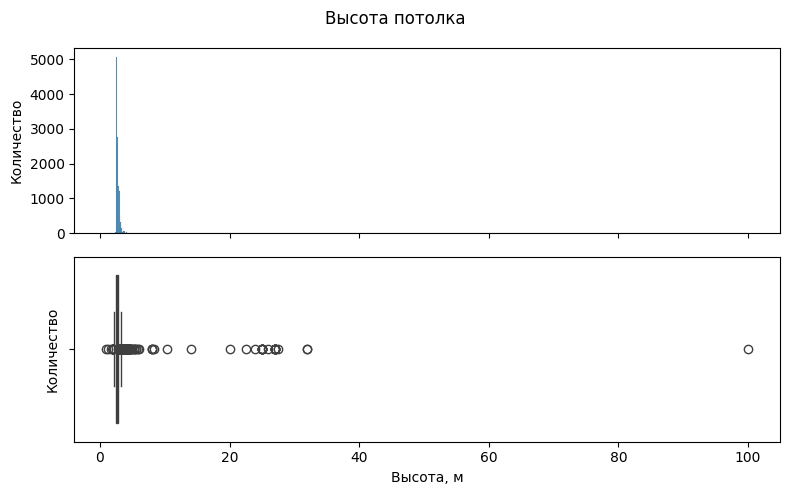

In [28]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8,5))
fig.suptitle('Высота потолка')
ax0 = sns.histplot(ax=axes[0], data=df, x="ceiling_height", binwidth=0.1, bins=30)
ax1 = sns.boxplot(ax=axes[1], data=df, x='ceiling_height', orient='h');
ax0.set_ylabel('Количество')
ax1.set_ylabel('Количество')
plt.xlabel('Высота, м')
plt.tight_layout()
plt.show()

Есть значительные выбросы. Если высота больше 20, то будем делить на 10. Вероятно записывая 25 или 27 имелось ввиду 2,5 и 2,7м.

In [29]:
df.loc[df['ceiling_height'] >= 20, 'ceiling_height'] = df['ceiling_height'] / 10

Еще раз смотрим распределение.

In [30]:
print('Пропусков:', df['ceiling_height'].isna().sum())
df['ceiling_height'].describe()

Пропусков: 9084


count               14481.00
mean                    2.73
std                     0.32
min                     1.00
25%                     2.51
50%                     2.65
75%                     2.80
max                    14.00
Name: ceiling_height, dtype: float64

У квартиры не может не быть высоты потолка. Если данных нет, заменим медианой. Считаем, проверяем.

In [31]:
print('Пропусков:', df['ceiling_height'].isna().sum())
ceiling_height_median = df['ceiling_height'].median()
print('Медиана высоты потолка:', ceiling_height_median)
df['ceiling_height'] = df['ceiling_height'].fillna(ceiling_height_median)
print('Пропусков:', df['ceiling_height'].isna().sum())
print('Строк всего:', df['ceiling_height'].count())

Пропусков: 9084
Медиана высоты потолка: 2.65
Пропусков: 0
Строк всего: 23565


Еще раз проверяем на выбросы

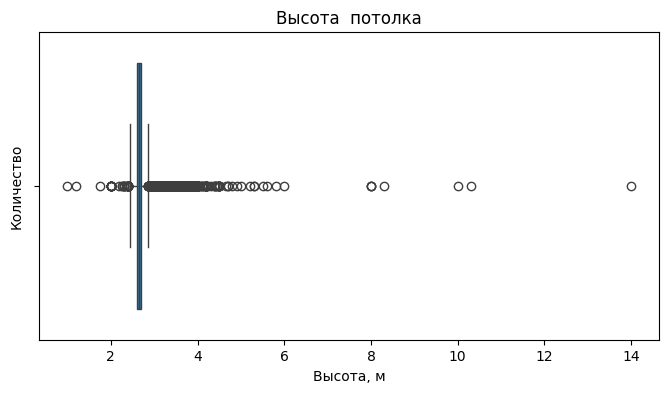

In [32]:
plt.figure(figsize=(8,4))
sns.boxplot(df['ceiling_height'], orient='h').set(title='Высота  потолка', xlabel='Высота, м', ylabel='Количество');

Все еще маловероятные значения, на что указывают выбросы. Будем считать выбросами все что меньше 2 и больше 5 метров. Удалим эти строки.

In [33]:
df.drop(df[(df['ceiling_height'] < 2) | (df['ceiling_height'] > 5)].index, inplace=True)

Квартиры с потолком выше 4,5 м. Их всего 5. Допускаем, что такие бывают. Оставляем.

In [34]:
df[df['ceiling_height'] > 4.5]['ceiling_height']

1053                    5.00
1300                    4.70
2802                    4.80
12401                   4.65
19142                   4.70
21923                   4.90
Name: ceiling_height, dtype: float64

Количество комнат.

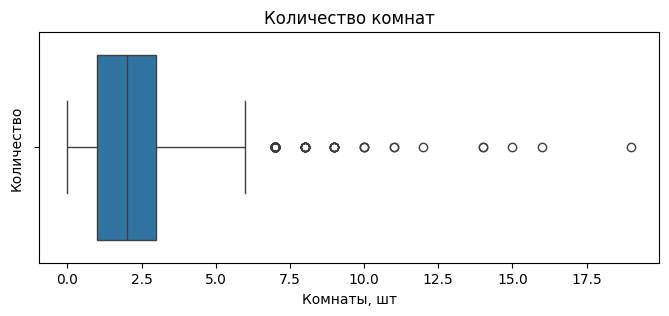

In [35]:
plt.figure(figsize=(8,3))
sns.boxplot(df['rooms'], orient='h').set(title='Количество комнат', xlabel='Комнаты, шт', ylabel='Количество')
plt.show()

Удаляем строки где комнат больше 6, проверяем.

In [36]:
print(df[df['rooms'] >= 6]['rooms'].count())
df = df[df.rooms < 6]
print(df[df['rooms'] >= 6]['rooms'].count())

193
0


Проверяем студии. 

In [37]:
print(df[df['rooms'] == 0][['rooms', 'studio']].value_counts())
print(df[df['rooms'] == 1][['rooms', 'studio']].value_counts())
print(df[df['rooms'] == 2][['rooms', 'studio']].value_counts())

rooms  studio
0      True      134
       False      59
Name: count, dtype: int64
rooms  studio
1      False     7987
       True        11
Name: count, dtype: int64
rooms  studio
2      False     7893
Name: count, dtype: int64


Если в объявлении указано квартира студия в 134 случаях указывают 0 комнат, в 11 объявлениях что 1 комната. Приведем в порядок. Укажем во всех студиях, что комнат 0. В объявлениях, где 0 комнат и это не студия, изменим на 1 комнату. Была ошибка при заполнении объявления.
Квартира не может продаваться без каких-то комнат.

In [38]:
df.loc[df['studio'] == True, 'rooms'] = 0
df.loc[(df['studio'] == False) & (df['rooms'] == 0), 'rooms'] = 1

In [39]:
# Проверяем. Во всех студиях 0 комнат.
print(df[df['rooms'] == 0][['rooms', 'studio']].value_counts())
print(df[df['rooms'] == 1][['rooms', 'studio']].value_counts())
print(df[df['rooms'] == 2][['rooms', 'studio']].value_counts())

rooms  studio
0      True      145
Name: count, dtype: int64
rooms  studio
1      False     8046
Name: count, dtype: int64
rooms  studio
2      False     7893
Name: count, dtype: int64


## Добавим новые столбцы

Цена 1 кв.м. Добавляем. проверяем.

In [40]:
df['price_per_square'] = (df['last_price'] / df['total_area']).round(2)
df.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square
8058,9,2280000,31.20,2017-09-13,1,2.55,5,17.40,1,False,False,False,5.60,0,Петергоф,37868,33058,1,294,3,298,100,73076.92
16615,15,3050000,72.00,2015-07-21,3,2.55,5,42.60,5,False,False,False,9.00,0,поселок Коробицыно,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,750,42361.11
18936,0,3500000,44.80,2018-07-20,2,2.65,7,NaN,1,False,False,False,0.00,0,Санкт-Петербург,19225,14850,2,77,1,178,45,78125.00
13816,16,40000000,128.00,2017-02-07,3,3.20,8,67.00,7,False,False,False,25.00,3,Санкт-Петербург,25846,5765,2,250,0,<NA>,90,312500.00
4371,1,8500000,74.00,2018-10-29,4,2.50,14,47.00,1,False,False,False,7.00,0,Санкт-Петербург,51623,15682,0,<NA>,1,530,4,114864.86


День размещения объявления (день недели) (0-понедельник, 6-воскресенье)

In [41]:
df['day_of_week'] = df['first_day_exposition'].dt.weekday

Месяц публикации объявления

In [42]:
df['month'] = df['first_day_exposition'].dt.month

Год публикации объявления

In [43]:
df['year'] = df['first_day_exposition'].dt.year

Тип этажа квартиры (значения — «первый», «последний», «другой»);

In [44]:
def make_floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

df['floor_type'] = df.apply(make_floor_type, axis=1)

Расстояние до центра города - переводим в км с округлением до целого

In [45]:
df['city_centers_nearest_km'] = (df['city_centers_nearest']/1000).astype(float).round()
df['city_centers_nearest_km'] = pd.array(df['city_centers_nearest_km'], dtype=pd.Int64Dtype())

Проверяем все что добавили.

In [46]:
df.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square,day_of_week,month,year,floor_type,city_centers_nearest_km
7108,18,4250000,44.50,2018-07-12,2,2.50,5,30.00,3,False,False,False,7.50,0,Санкт-Петербург,42437,14941,1,187,0,<NA>,20,95505.62,3,7,2018,другой,15
7390,5,5200000,80.00,2017-09-11,4,2.50,5,52.00,2,False,False,False,7.00,0,Санкт-Петербург,42337,9359,1,823,0,<NA>,377,65000.00,0,9,2017,другой,9
11978,14,4800000,65.00,2016-05-25,3,2.60,10,42.00,8,False,False,False,7.60,0,Кронштадт,64931,46657,1,498,1,723,525,73846.15,2,5,2016,другой,47
11916,15,6500000,55.00,2018-10-25,1,2.77,16,25.00,12,False,False,False,12.00,0,Санкт-Петербург,33827,12489,0,<NA>,0,<NA>,92,118181.82,3,10,2018,другой,12
2971,11,7000000,65.00,2018-12-06,3,2.60,14,41.70,8,False,False,False,8.00,1,Санкт-Петербург,33446,11459,1,487,1,759,<NA>,107692.31,3,12,2018,другой,11


## Исследовательский анализ данных

In [47]:
df.count()

total_images               23355
last_price                 23355
total_area                 23355
first_day_exposition       23355
rooms                      23355
ceiling_height             23355
floors_total               23355
living_area                21505
floor                      23355
is_apartment               23355
studio                     23355
open_plan                  23355
kitchen_area               23355
balcony                    23355
locality_name              23355
airports_nearest           17839
city_centers_nearest       17861
parks_around3000           17862
parks_nearest               7889
ponds_around3000           17862
ponds_nearest               8898
days_exposition            20243
price_per_square           23355
day_of_week                23355
month                      23355
year                       23355
floor_type                 23355
city_centers_nearest_km    17861
dtype: int64

Все строки заполнены?
Изучим отдельные параметры. Общая площадь. Изучать лучше наглядно. Выведем список максимальных значений площади.

In [48]:
print('Самая частая площадь квартир в объявлениях:', df.total_area.mode()[0])
print(df.total_area.describe())
print(df.total_area.sort_values(ascending=False)[:250].tolist())

Самая частая площадь квартир в объявлениях: 45.0
count               23355.00
mean                   58.82
std                    30.04
min                    12.00
25%                    40.00
50%                    51.90
75%                    69.00
max                   507.00
Name: total_area, dtype: float64
[507.0, 500.0, 494.1, 491.0, 488.0, 470.3, 441.98, 422.2, 401.0, 380.0, 371.0, 365.0, 363.1, 342.0, 336.0, 323.0, 317.0, 315.0, 312.0, 310.0, 307.8, 304.0, 295.0, 293.6, 290.0, 288.0, 284.0, 283.3, 283.0, 280.0, 280.0, 280.0, 275.0, 274.0, 268.0, 267.7, 266.2, 263.8, 260.0, 260.0, 259.6, 259.2, 256.0, 255.0, 254.0, 251.0, 251.0, 250.3, 250.2, 250.0, 250.0, 250.0, 249.7, 248.7, 245.8, 243.0, 242.4, 241.0, 240.0, 240.0, 240.0, 239.0, 238.26, 237.8, 237.8, 236.0, 235.0, 235.0, 234.0, 232.0, 231.6, 230.1, 230.0, 230.0, 230.0, 230.0, 228.0, 228.0, 228.0, 224.5, 224.3, 223.0, 222.6, 222.0, 222.0, 222.0, 222.0, 222.0, 221.0, 220.0, 220.0, 220.0, 216.0, 215.2, 215.0, 215.0, 215.0, 214.

Построим графки распределения.

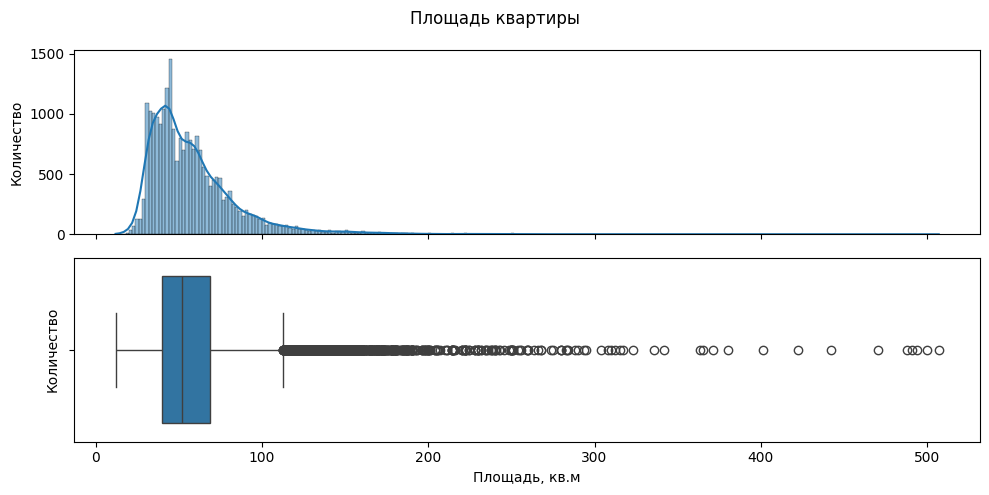

In [49]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.suptitle('Площадь квартиры')
ax0 = sns.histplot(ax=axes[0], data=df, x="total_area", kde=True, binwidth=2, bins=30)
ax1 = sns.boxplot(ax=axes[1], data=df, x='total_area', orient='h');
ax0.set_ylabel('Количество')
ax1.set_ylabel('Количество')
plt.xlabel('Площадь, кв.м')
plt.tight_layout()
plt.show()

Выбрсы присутствуют. Удаляем квартиры с площадью больше 200 м. Проверяем.

In [50]:
print(df.query('total_area > 200')['total_area'].count())
# Удаляем такие записи.
df = df[df.total_area < 200]
print(df.query('total_area > 200')['total_area'].count())

115
0


Самая частая площадь квартир в объявлениях: 45.0
count               23236.00
mean                   57.77
std                    25.76
min                    12.00
25%                    40.00
50%                    51.50
75%                    68.30
max                   199.20
Name: total_area, dtype: float64


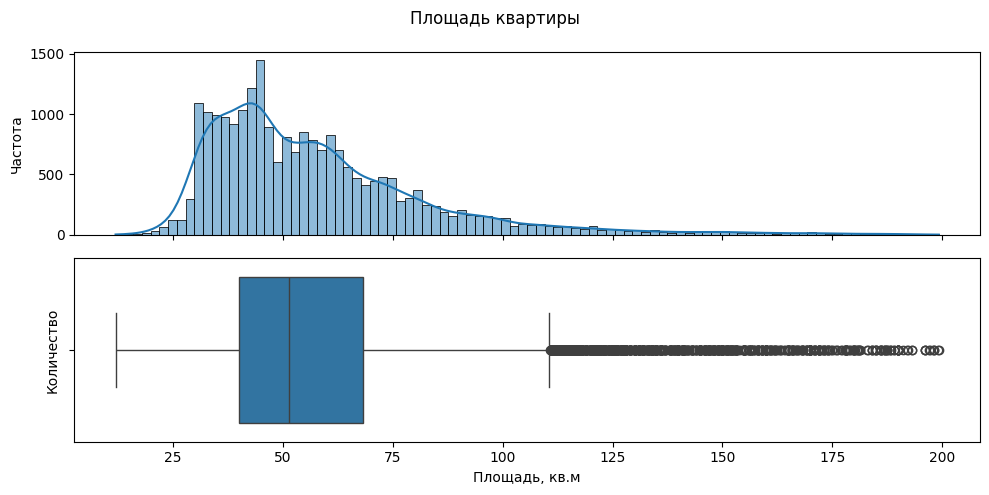

In [51]:
print('Самая частая площадь квартир в объявлениях:', df.total_area.mode()[0])
print(df.total_area.describe())

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.suptitle('Площадь квартиры')
ax0 = sns.histplot(ax=axes[0], data=df, x="total_area", kde=True, binwidth=2, bins=30)
ax1 = sns.boxplot(ax=axes[1], data=df, x='total_area', orient='h');
ax0.set_ylabel('Частота')
ax1.set_ylabel('Количество')
plt.xlabel('Площадь, кв.м')
plt.tight_layout()
plt.show()

Больше всего объявлений о продаже квартир площадью 45 кв.м. Минимальная квартира - 12 кв.м. Максимальная после очистки данных - 199 кв.м.
Посмотрим распределение жилой площади.

Самая частая жилая площадь квартир в объявлениях: 18.0
count               21406.00
mean                   32.96
std                    16.71
min                     2.00
25%                    18.50
50%                    30.00
75%                    42.00
max                   164.70
Name: living_area, dtype: float64


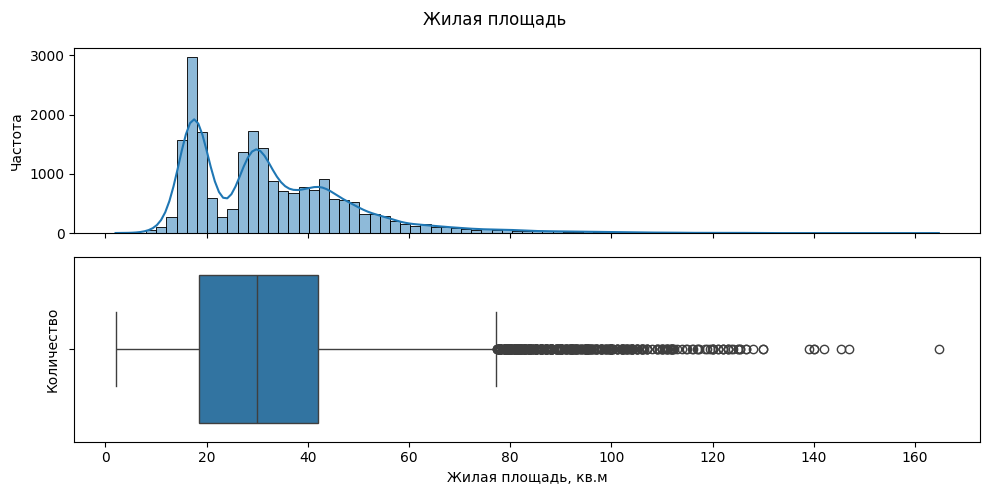

In [52]:
print('Самая частая жилая площадь квартир в объявлениях:', df.living_area.mode()[0])
print(df.living_area.describe())
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.suptitle('Жилая площадь')
ax0 = sns.histplot(ax=axes[0], data=df, x='living_area', kde=True, binwidth=2, bins=130)
ax1 = sns.boxplot(ax=axes[1], data=df, x='living_area', orient='h');
ax0.set_ylabel('Частота')
ax1.set_ylabel('Количество')
plt.xlabel('Жилая площадь, кв.м')
plt.tight_layout()
plt.show()

Запределение площади квартиры от количества комнат.

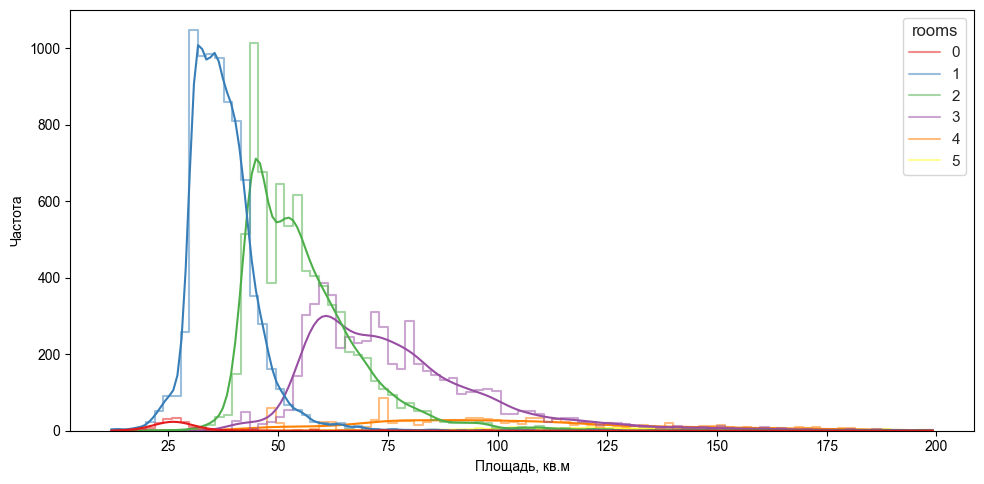

In [53]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,5))
sns.set(style = "whitegrid")
palette = sns.color_palette('Set1', 6)
ax = sns.histplot(data = df, x='total_area', hue='rooms', element='step', color='Set2', kde=True, palette=palette,
             alpha=0.5, fill=False)
plt.ylabel('Частота')
plt.xlabel('Площадь, кв.м')
plt.tight_layout()
plt.show()

In [54]:
df[['living_area', 'total_area']]
print('Количество нулевых значений жилой площади:', df[df['living_area'] == 0]['living_area'].count())
print('Количество пропущенныйх значений жилой площади:',df['living_area'].isna().sum())

Количество нулевых значений жилой площади: 0
Количество пропущенныйх значений жилой площади: 1830


Жилая площадь не указана - 1830 объявлений. Проверим чтобы жилая площадь была меньше общей площади.

In [55]:
print(df[(df['living_area'] > df['total_area'])]['living_area'].count())

0


ЗАПОЛНЯЕМ ПРОПУСКИ НУЛЯМИ.

In [56]:
df['living_area'] = df['living_area'].fillna(0)

Найдем среднее соотношение общей и жилой площади и заменим нулевые значения пропороциональным числом добавим новую колонку соотношения.

In [57]:
df['living_total_ratio'] = df['living_area'] / df['total_area']

Проверим что колонка добавилась

In [58]:
df.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square,day_of_week,month,year,floor_type,city_centers_nearest_km,living_total_ratio
6223,9,3730000,57.70,2017-06-02,3,2.50,9,39.50,3,False,False,False,6.20,0,поселок Металлострой,25027,26739,0,<NA>,0,<NA>,328,64644.71,4,6,2017,другой,27,0.68
2422,6,4700000,56.40,2016-06-27,2,2.65,6,34.00,6,False,False,False,11.00,0,Санкт-Петербург,32899,5126,0,<NA>,2,606,401,83333.33,0,6,2016,последний,5,0.60
17137,16,4250000,42.20,2017-06-22,1,2.65,16,16.50,10,False,False,False,12.80,0,Санкт-Петербург,11875,14467,0,<NA>,1,330,134,100710.90,3,6,2017,другой,14,0.39
5412,1,3960000,64.90,2018-01-10,2,2.60,8,37.50,2,False,False,False,13.40,2,Всеволожск,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,237,61016.95,2,1,2018,другой,<NA>,0.58
14976,9,5705000,39.00,2018-06-02,1,2.50,5,17.00,5,False,False,False,9.00,0,Санкт-Петербург,19626,4381,1,220,1,324,79,146282.05,5,6,2018,последний,4,0.44


Найдем среднее значение соотношения среди значениий не равных нулю

In [59]:
living_total_ratio_mean = df[df['living_total_ratio'] != 0]['living_total_ratio'].mean()
print(living_total_ratio_mean)

0.5641154329614874


Присвоим нулевым значения жилой площади значения пропорциональные общей умноженной на living_total_ratio_mean

Самая частая жилая площадь квартир в объявлениях: 18.0
count               23236.00
mean                   32.98
std                    16.63
min                     2.00
25%                    19.00
50%                    30.00
75%                    41.90
max                   164.70
Name: living_area, dtype: float64


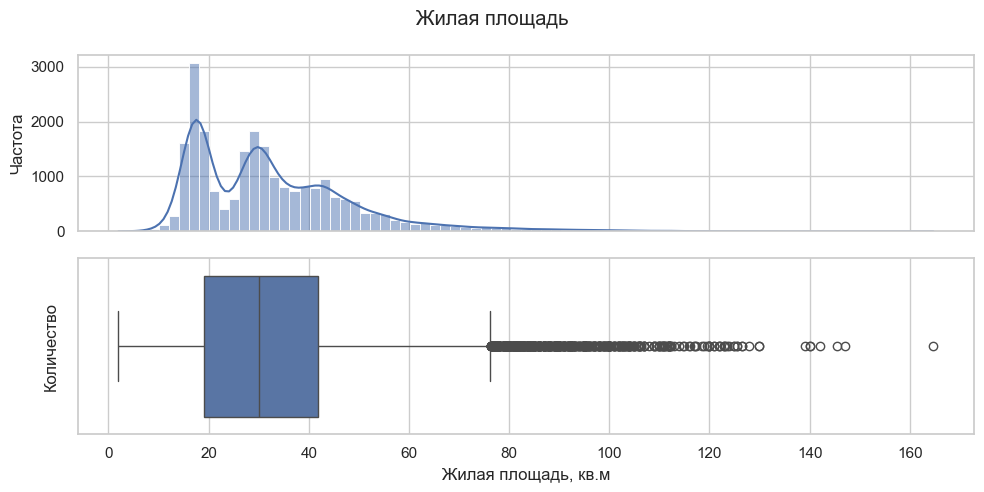

In [60]:
df.loc[df['living_area'] == 0, 'living_area'] = round((df['total_area'] * living_total_ratio_mean), 1)

print('Самая частая жилая площадь квартир в объявлениях:', df.living_area.mode()[0])
print(df.living_area.describe())
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.suptitle('Жилая площадь')
ax0 = sns.histplot(ax=axes[0], data=df, x='living_area', kde=True, binwidth=2, bins=130)
ax1 = sns.boxplot(ax=axes[1], data=df, x='living_area', orient='h');
ax0.set_ylabel('Частота')
ax1.set_ylabel('Количество')
plt.xlabel('Жилая площадь, кв.м')
plt.tight_layout()
plt.show()

Вывод: минимальная жилая площадь равна 2 кв.м. Самая распространенная жилая площадь 18 кв.м. Максимальная - 164 кв.м.

Прощадь кухни

Самая частая площадь кухни в объявлениях: 0.0
count               23236.00
mean                    9.38
std                     5.92
min                     0.00
25%                     6.30
50%                     8.90
75%                    11.30
max                    93.20
Name: kitchen_area, dtype: float64


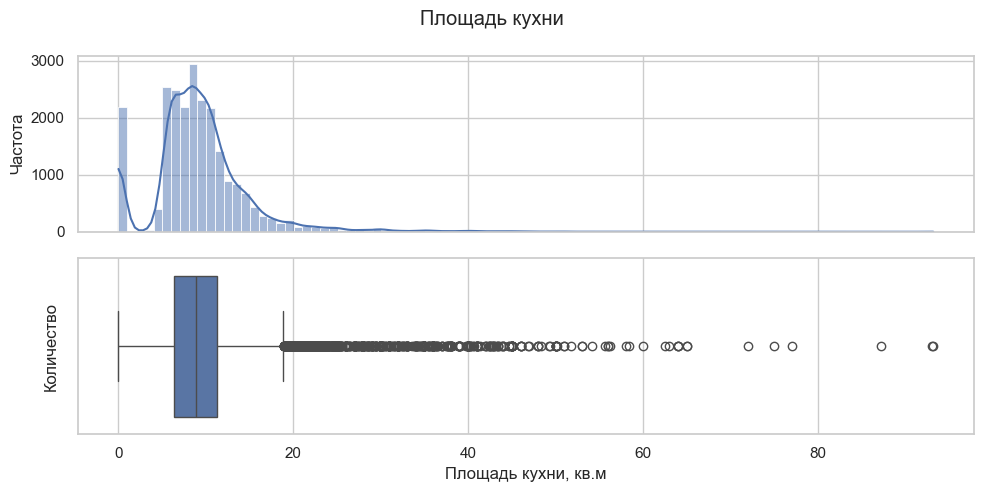

In [61]:
print('Самая частая площадь кухни в объявлениях:', df.kitchen_area.mode()[0])
print(df.kitchen_area.describe())
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.suptitle('Площадь кухни')
ax0 = sns.histplot(ax=axes[0], data=df, x='kitchen_area', kde=True, binwidth=1, bins=150)
ax1 = sns.boxplot(ax=axes[1], data=df, x='kitchen_area', orient='h');
ax0.set_ylabel('Частота')
ax1.set_ylabel('Количество')
plt.xlabel('Площадь кухни, кв.м')
plt.tight_layout()
plt.show()

Сново много нулевых знаений. Мода = 0. Исключаем нули из подсчета.

Самая частая площадь кухни 6.0
count               21055.00
mean                   10.35
std                     5.35
min                     1.30
25%                     7.00
50%                     9.00
75%                    11.90
max                    93.20
Name: kitchen_area, dtype: float64


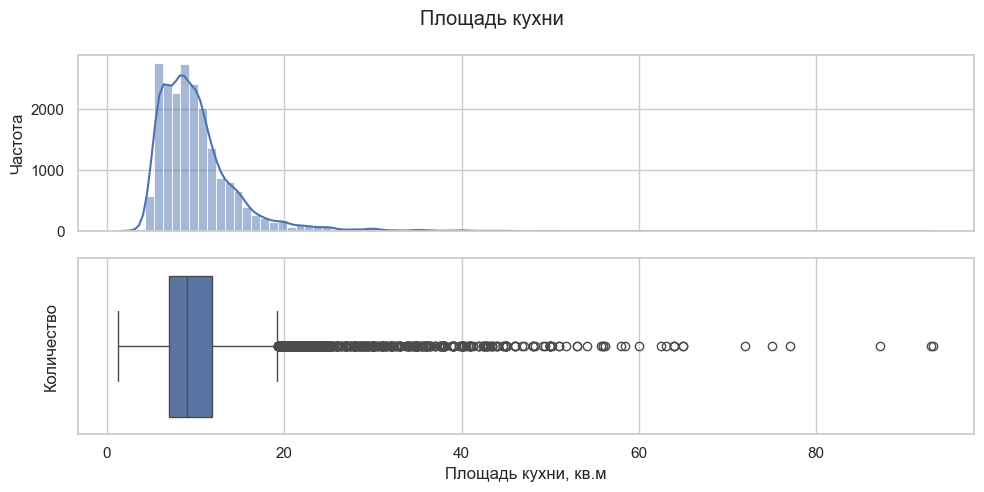

In [62]:
print('Самая частая площадь кухни', df[df['kitchen_area'] != 0].kitchen_area.mode()[0])
temp = df[df['kitchen_area'] != 0]
print(temp['kitchen_area'].describe())
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.suptitle('Площадь кухни')
ax0 = sns.histplot(ax=axes[0], data=temp, x='kitchen_area', kde=True, binwidth=1, bins=150)
ax1 = sns.boxplot(ax=axes[1], data=temp, x='kitchen_area', orient='h');
ax0.set_ylabel('Частота')
ax1.set_ylabel('Количество')
plt.xlabel('Площадь кухни, кв.м')
plt.tight_layout()
plt.show()

Площадь кухни самая распространенная - 6 кв.м. Минимальная 1,3 кв.м. Медианная - 9 кв.м., максимум 93 кв.м.

Изучаем цену объекта

Самая частая цена в объявлениях: 4500000
count               23236.00
mean              5972103.13
std               6136960.98
min                 12190.00
25%               3400000.00
50%               4600000.00
75%               6650000.00
max             330000000.00
Name: last_price, dtype: float64


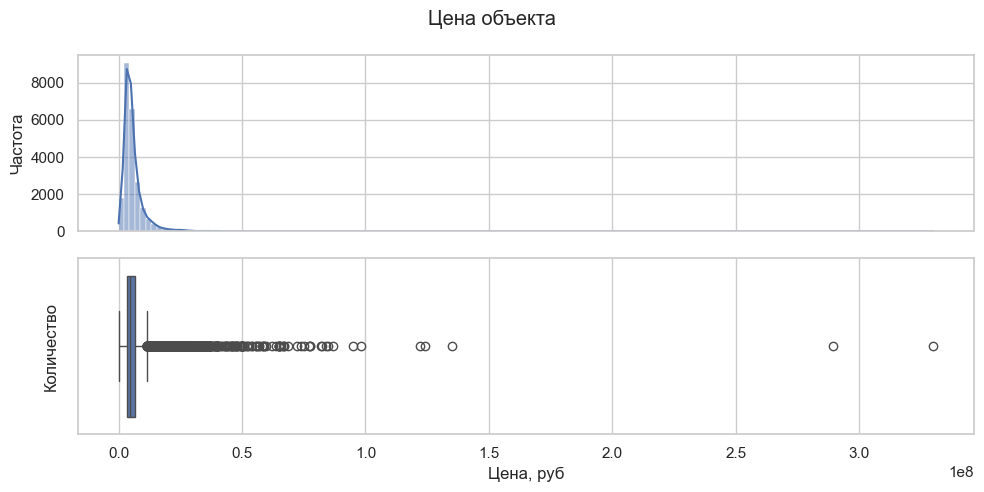

In [63]:
print('Самая частая цена в объявлениях:', df.last_price.mode()[0])
print(df.last_price.describe())
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.suptitle('Цена объекта')
# ax0 = sns.histplot(ax=axes[0], data=df, x='last_price', kde=True, binwidth=1, bins=150)
ax0 = sns.histplot(ax=axes[0], data=df, x='last_price', kde=True, bins=150)
ax1 = sns.boxplot(ax=axes[1], data=df, x='last_price', orient='h');
ax0.set_ylabel('Частота')
ax1.set_ylabel('Количество')
plt.xlabel('Цена, руб')
plt.tight_layout()
plt.show()

Квартиры могут быть очень дорогие максимум в этой выборке 330 млн руб. Но такие объекты будут искажать выводы.
Уберем все объекты стоимостью больше 80 млн. руб. 
и стоимостью меньше 100 тыс. руб

In [64]:
df = df[df.last_price < 80000000]
df = df[df.last_price > 100000]

Для наглядности разделим стоиммость квавртиры на 1 млн. руб, чтобы они пришли в более понятный вид.

In [65]:
df['last_price_mln'] = (df['last_price']/1000000).round(2)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square,day_of_week,month,year,floor_type,city_centers_nearest_km,living_total_ratio,last_price_mln
0,20,13000000,108.00,2019-03-07,3,2.70,16,51.00,8,False,False,False,25.00,0,Санкт-Петербург,18863,16028,1,482,2,755,<NA>,120370.37,3,3,2019,другой,16,0.47,13.00
1,7,3350000,40.40,2018-12-04,1,2.65,11,18.60,1,False,False,False,11.00,2,поселок Шушары,12817,18603,0,<NA>,0,<NA>,81,82920.79,1,12,2018,первый,19,0.46,3.35
2,10,5196000,56.00,2015-08-20,2,2.65,5,34.30,4,False,False,False,8.30,0,Санкт-Петербург,21741,13933,1,90,2,574,558,92785.71,3,8,2015,другой,14,0.61,5.20
3,0,64900000,159.00,2015-07-24,3,2.65,14,89.70,9,False,False,False,0.00,0,Санкт-Петербург,28098,6800,2,84,3,234,424,408176.10,4,7,2015,другой,7,0.00,64.90
4,2,10000000,100.00,2018-06-19,2,3.03,14,32.00,13,False,False,False,41.00,0,Санкт-Петербург,31856,8098,2,112,1,48,121,100000.00,1,6,2018,другой,8,0.32,10.00


И сновав смотрим на распределение

Самая частая цена в объявлениях: 4.5
count               23223.00
mean                    5.91
std                     5.08
min                     0.43
25%                     3.40
50%                     4.60
75%                     6.65
max                    77.61
Name: last_price_mln, dtype: float64


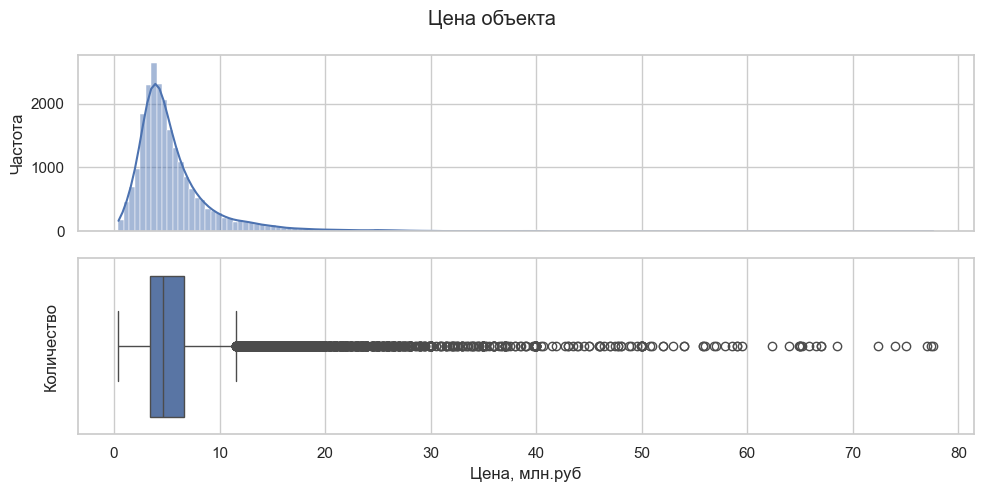

In [66]:
print('Самая частая цена в объявлениях:', df.last_price_mln.mode()[0])
print(df.last_price_mln.describe())
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.suptitle('Цена объекта')
# ax0 = sns.histplot(ax=axes[0], data=df, x='last_price', kde=True, binwidth=1, bins=150)
ax0 = sns.histplot(ax=axes[0], data=df, x='last_price_mln', kde=True, bins=150)
ax1 = sns.boxplot(ax=axes[1], data=df, x='last_price_mln', orient='h');
ax0.set_ylabel('Частота')
ax1.set_ylabel('Количество')
plt.xlabel('Цена, млн.руб')
plt.tight_layout()
plt.show()

Самая популярная цена в объявлениях о продаже 4,5 млн. руб. За самое недорогое жилье просят 430 тыс. руб. 
За самое дорогое - больше 77 млн. Средняя стоимость квартиры на площадке 5,9 млн. Медианное значение - 4,6 млн.

Чаще всего количество комнат в объявлениях: 1
count               23223.00
mean                    2.02
std                     0.96
min                     0.00
25%                     1.00
50%                     2.00
75%                     3.00
max                     5.00
Name: rooms, dtype: float64


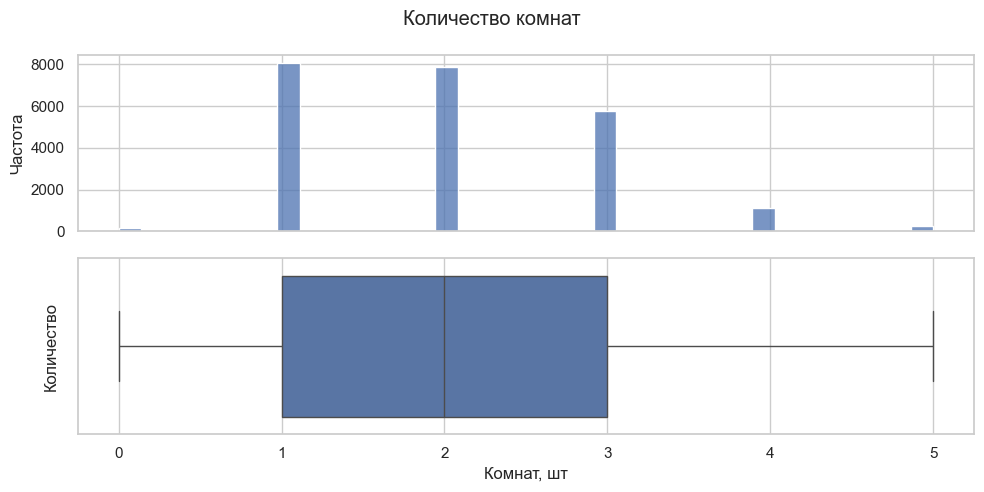

In [67]:
print('Чаще всего количество комнат в объявлениях:', df.rooms.mode()[0])
print(df.rooms.describe())
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.suptitle('Количество комнат')
# ax0 = sns.histplot(ax=axes[0], data=df, x='last_price', kde=True, binwidth=1, bins=150)
ax0 = sns.histplot(ax=axes[0], data=df, x='rooms', bins='auto')
ax1 = sns.boxplot(ax=axes[1], data=df, x='rooms', orient='h');
ax0.set_ylabel('Частота')
ax1.set_ylabel('Количество')
plt.xlabel('Комнат, шт')
plt.tight_layout()
plt.show()

Больше всего объявлений о продаже однушек. И по уменьшению популярности: 2, 3, 4, 5 комнатные квартиры. И студии.

Чаще всего высота потолков в объявлениях: 2.65
count               23223.00
mean                    2.69
std                     0.20
min                     2.00
25%                     2.60
50%                     2.65
75%                     2.70
max                     5.00
Name: ceiling_height, dtype: float64


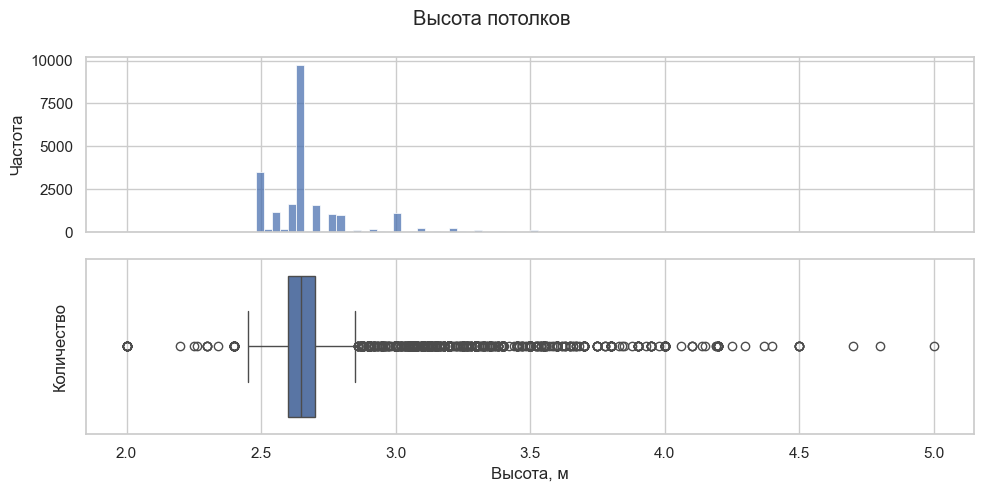

In [68]:
print('Чаще всего высота потолков в объявлениях:', df.ceiling_height.mode()[0])
print(df.ceiling_height.describe())
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.suptitle('Высота потолков')
# ax0 = sns.histplot(ax=axes[0], data=df, x='last_price', kde=True, binwidth=1, bins=150)
ax0 = sns.histplot(ax=axes[0], data=df, x='ceiling_height', bins=100)
ax1 = sns.boxplot(ax=axes[1], data=df, x='ceiling_height', orient='h');
ax0.set_ylabel('Частота')
ax1.set_ylabel('Количество')
plt.xlabel('Высота, м')
plt.tight_layout()
plt.show()

Наиболее распространенная высота потолков 2,65. Максимум ограничили 5 м, минимум 2 метрами. Возможно данные можно еще поджать к середине.

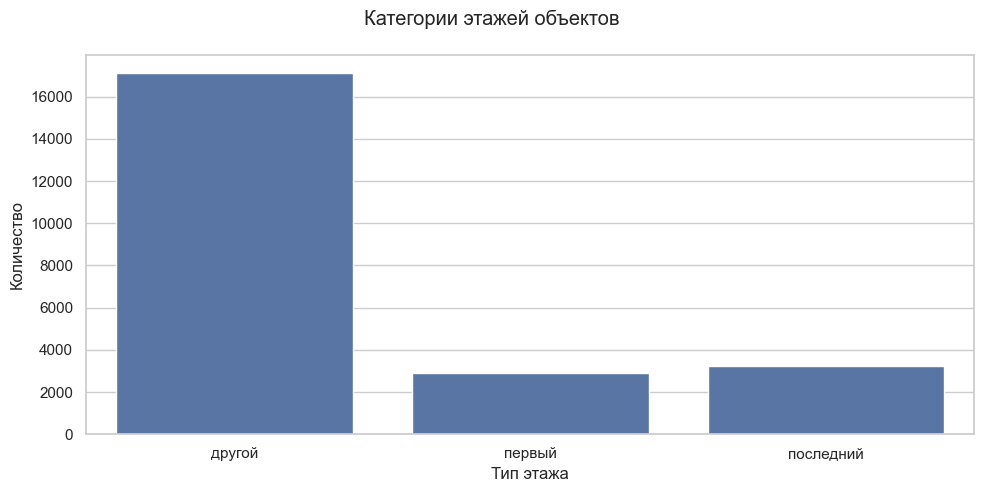

In [69]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Категории этажей объектов')
sns.countplot(x='floor_type', data=df)
plt.xlabel('Тип этажа')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

Наиболее часто встречаются квартины не первых и не последних этажей, что логично.

Анализируем количество этажей в доме floors_total. Исключаем объявления где не указана этажность дома.

Чаще всего количество этажей в объявлениях: 5
count               23223.00
mean                   10.74
std                     6.61
min                     1.00
25%                     5.00
50%                     9.00
75%                    16.00
max                    60.00
Name: floors_total, dtype: float64


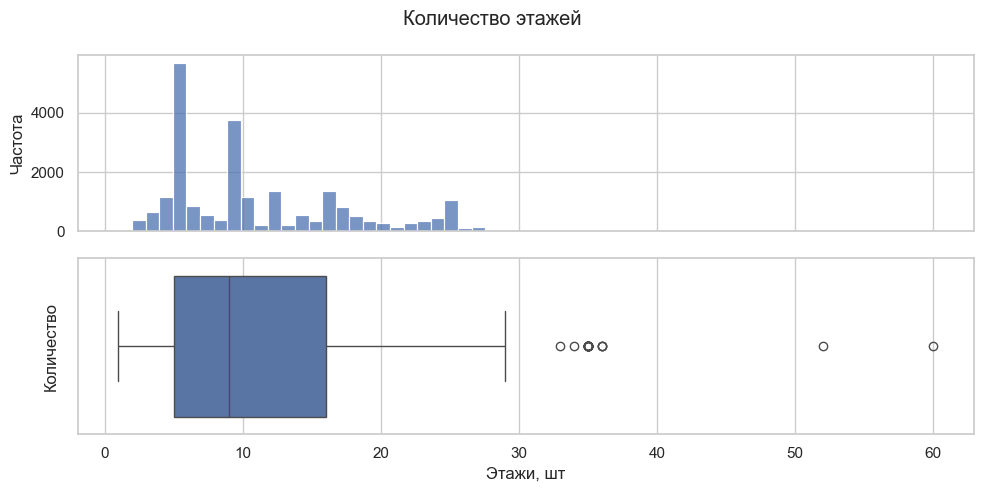

In [70]:
print('Чаще всего количество этажей в объявлениях:', df.floors_total.mode()[0])
print(df.floors_total[df.floors_total != 0].describe())
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.suptitle('Количество этажей')
ax0 = sns.histplot(ax=axes[0], data=df, x='floors_total', bins=60)
ax1 = sns.boxplot(ax=axes[1], data=df, x='floors_total', orient='h');
ax0.set_ylabel('Частота')
ax1.set_ylabel('Количество')
plt.xlabel('Этажи, шт')
plt.tight_layout()
plt.show()

Дома, где больше 30 этажей можно исключить как аномальные.

Чаще всего количество этажей в объявлениях: 5
count               23192.00
mean                   10.70
std                     6.54
min                     1.00
25%                     5.00
50%                     9.00
75%                    16.00
max                    29.00
Name: floors_total, dtype: float64


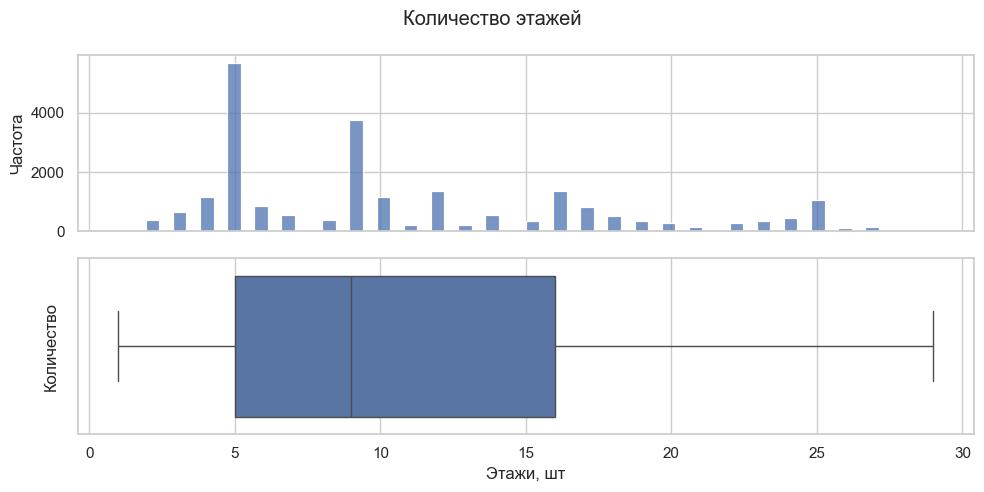

In [71]:
df = df[df.floors_total < 30]
print('Чаще всего количество этажей в объявлениях:', df.floors_total.mode()[0])
print(df.floors_total[df.floors_total != 0].describe())
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.suptitle('Количество этажей')
ax0 = sns.histplot(ax=axes[0], data=df, x='floors_total', bins=60)
ax1 = sns.boxplot(ax=axes[1], data=df, x='floors_total', orient='h');
ax0.set_ylabel('Частота')
ax1.set_ylabel('Количество')
plt.xlabel('Этажи, шт')
plt.tight_layout()
plt.show()

Минимальная этажность 1, максимальная - 29 этажей. Самые распространенные объявления с квартирами в - 5-этажках и 9-этажках. Таких домов больше других.

Расстояние до центра города в метрах - city_centers_nearest. Исключаем при подсчете нулевые значения и значения больше 35000

Самое частое расстояние до ценетра города в объявлениях: 8460
count               17700.00
mean                14321.28
std                  8586.42
min                   181.00
25%                  9496.00
50%                 13171.00
75%                 16315.25
max                 65968.00
Name: city_centers_nearest, dtype: Float64


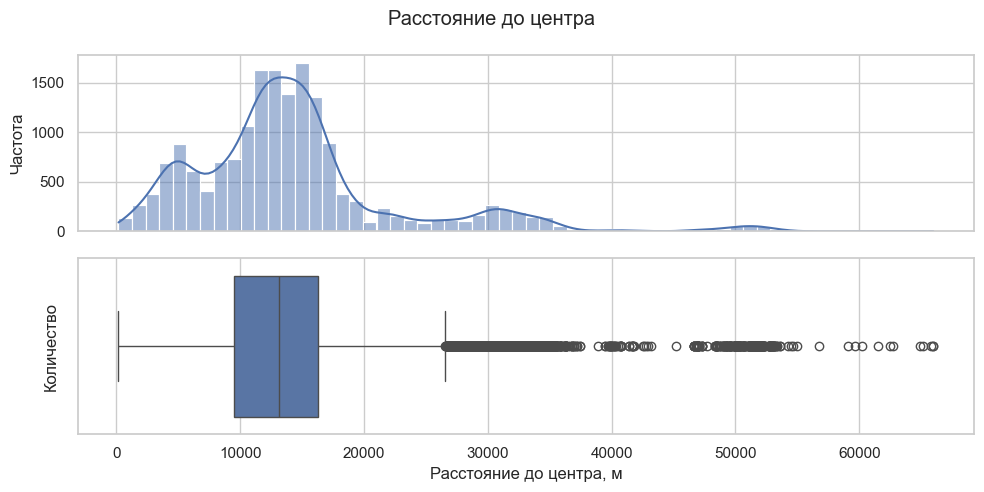

In [72]:
print('Самое частое расстояние до ценетра города в объявлениях:', df.city_centers_nearest.mode()[0])
print(df.city_centers_nearest[df.city_centers_nearest != 0].describe())
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.suptitle('Расстояние до центра')
ax0 = sns.histplot(ax=axes[0], data=df, x='city_centers_nearest', bins=60, kde=True)
ax1 = sns.boxplot(ax=axes[1], data=df, x='city_centers_nearest', orient='h');
ax0.set_ylabel('Частота')
ax1.set_ylabel('Количество')
plt.xlabel('Расстояние до центра, м')
plt.tight_layout()
plt.show()

Уберем экстремальные значения, где расстояние до центра больше 35000 м и не равны нулю

Самое частое расстояние до ценетра города в объявлениях: 8460
count               17277.00
mean                13545.19
std                  7000.15
min                   181.00
25%                  9360.00
50%                 13037.00
75%                 16062.00
max                 34970.00
Name: city_centers_nearest, dtype: Float64


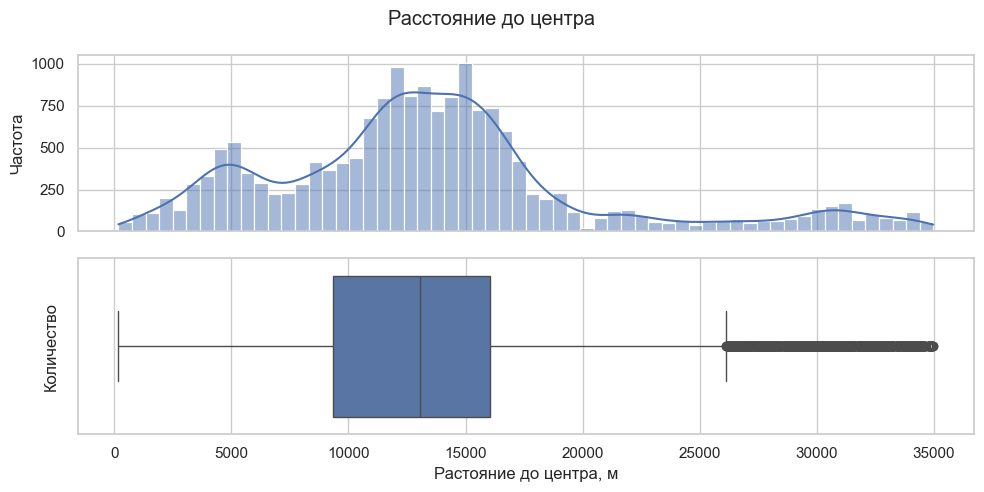

In [73]:
tdf = df[(df.city_centers_nearest != 0) & (df.city_centers_nearest < 35000)]
print('Самое частое расстояние до ценетра города в объявлениях:', df.city_centers_nearest.mode()[0])
print(tdf.city_centers_nearest[tdf.city_centers_nearest != 0].describe())
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.suptitle('Расстояние до центра')
ax0 = sns.histplot(ax=axes[0], data=tdf, x='city_centers_nearest', bins=60, kde=True)
ax1 = sns.boxplot(ax=axes[1], data=tdf, x='city_centers_nearest', orient='h');
ax0.set_ylabel('Частота')
ax1.set_ylabel('Количество')
plt.xlabel('Растояние до центра, м')
plt.tight_layout()
plt.show()

Мода расстояния от центра города - 8,5 км. 75% объявлений о квартирах с расстоянием до центра не более 16 км. Половина всех квартир расположена в пределах расстояния от центра 9 до 16 км.

Расстояние до ближайшего парка - parks_nearest. Исключаем при подсчете нулевые значения.

Самое частое расстояние до парка в объявлениях: 441
count                7796.00
mean                  492.51
std                   343.56
min                     1.00
25%                   288.00
50%                   456.00
75%                   614.00
max                  3190.00
Name: parks_nearest, dtype: Float64


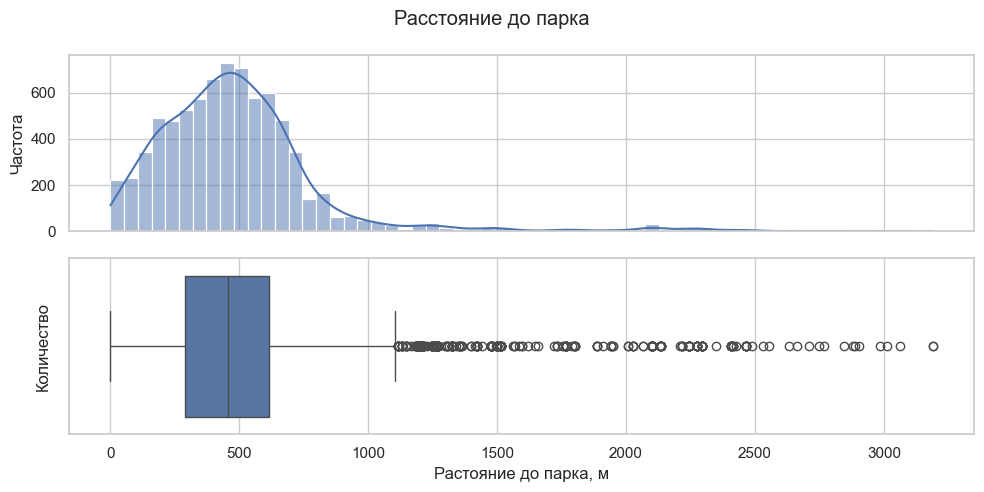

In [74]:
# tdf = df[(df.parks_nearest != 0) & (df.parks_nearest < 35000)]
tdf = df[(df.parks_nearest != 0)]
print('Самое частое расстояние до парка в объявлениях:', tdf.parks_nearest.mode()[0])
print(tdf.parks_nearest[tdf.parks_nearest != 0].describe())
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.suptitle('Расстояние до парка')
ax0 = sns.histplot(ax=axes[0], data=tdf, x='parks_nearest', bins=60, kde=True)
ax1 = sns.boxplot(ax=axes[1], data=tdf, x='parks_nearest', orient='h');
ax0.set_ylabel('Частота')
ax1.set_ylabel('Количество')
plt.xlabel('Растояние до парка, м')
plt.tight_layout()
plt.show()

В среднем в объявлениях до парка около 500 метров. Чаще всего указано 441 м. Максимальное расстояние до парка в объявления более 3 км.

Изучаем как быстро продавались квартиры (столбец days_exposition). #Этот параметр показывает, сколько дней было размещено каждое объявление. Из расчетов удалим количество дней равно 0.

Самое частое количество дней продажи объекта в объявлениях: 45
count               20114.00
mean                  179.30
std                   218.19
min                     1.00
25%                    45.00
50%                    94.50
75%                   229.00
max                  1580.00
Name: days_exposition, dtype: Float64


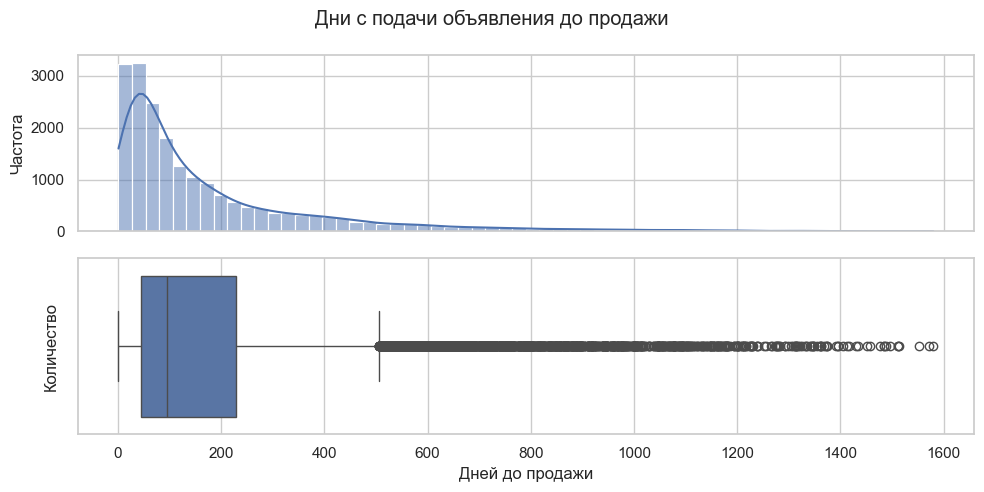

Среднее: 179.3
Медиана: 94.5


In [75]:
tdf = df[df.days_exposition != 0]
print('Самое частое количество дней продажи объекта в объявлениях:', tdf.days_exposition.mode()[0])
print(tdf.days_exposition.describe())
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.suptitle('Дни с подачи объявления до продажи')
ax0 = sns.histplot(ax=axes[0], data=tdf, x='days_exposition', bins=60, kde=True)
ax1 = sns.boxplot(ax=axes[1], data=tdf, x='days_exposition', orient='h');
ax0.set_ylabel('Частота')
ax1.set_ylabel('Количество')
plt.xlabel('Дней до продажи')
plt.tight_layout()
plt.show()
print('Среднее:', tdf.days_exposition.mean().round(2))
print('Медиана:', tdf.days_exposition.median().round(2))

count               20114.00
mean                  179.30
std                   218.19
min                     1.00
25%                    45.00
50%                    94.50
75%                   229.00
max                  1580.00
Name: days_exposition, dtype: Float64


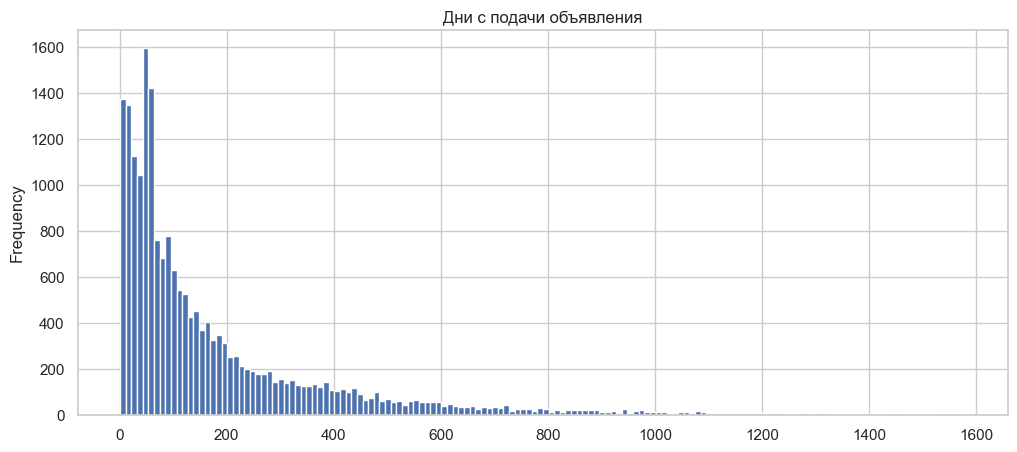

Среднее: 179.3
Медиана: 94.5


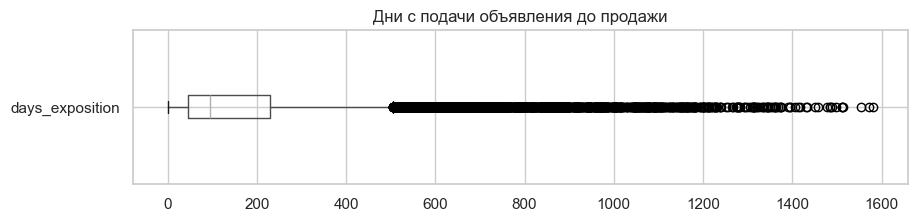

In [76]:
tdf = df[df.days_exposition != 0]
#print(df.head())
#В ячейке типа markdown опишите, сколько времени обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?
print(tdf.days_exposition.describe())
(tdf.days_exposition.plot(
    kind='hist', bins=150, title='Дни с подачи объявления', figsize=(12,5)));
plt.show()
tdf.boxplot(column=['days_exposition'], grid=True, vert=False, figsize=(10,2)).set_title('Дни с подачи объявления до продажи');
print('Среднее:', tdf.days_exposition.mean().round(2))
print('Медиана:', tdf.days_exposition.median().round(2))

В среднем квартира продается за 3 месяца (95 дней). Быстрые продажи - менее 45 дней. Необычно долгие продажи - более 229 дней. Максимальное размещение в выборке - 1580 дней.

Посмотрим какие квартириры продаются быстрее - где больше комнат или где меньше.

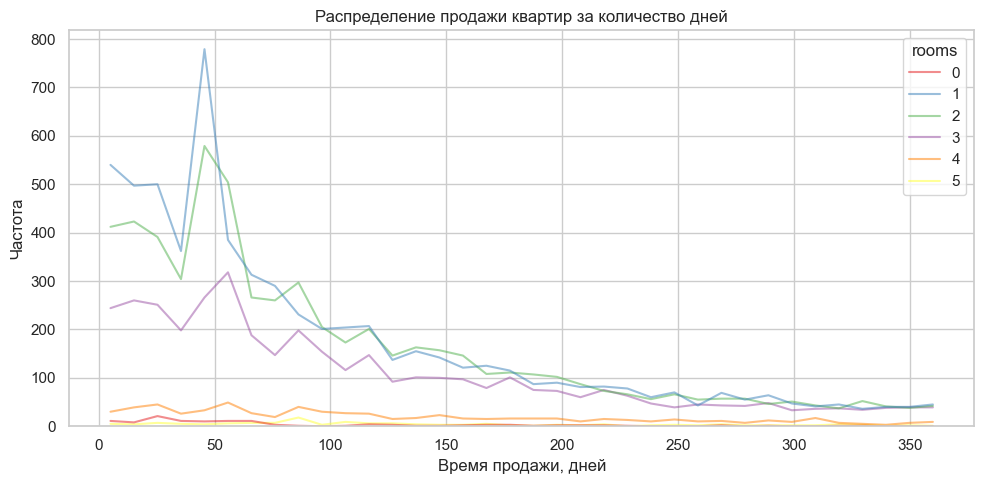

In [77]:
fig, axes = plt.subplots(figsize=(10,5))
sns.set(style = "whitegrid")
palette = sns.color_palette('Set1', 6)

sns.histplot(data=tdf, x='days_exposition', hue='rooms', palette=palette, 
             color='Set2', 
             fill=False, 
             alpha=0.5,
             element="poly",
             binrange=(0, 365), #bins=30,
             binwidth=10)

plt.title('Распределение продажи квартир за количество дней')
plt.ylabel('Частота')
plt.xlabel('Время продажи, дней')
plt.tight_layout()
plt.show()

Видно, что чаще всего квартиры продаются в течении 50 дней с момента подачи объявления. 1 и 2-х комнатные немного быстртее чем 3-х комнатные. По квартирам-студиямм и квартирам с 4 и более комнатами нет четких сроков продажи.

Распределение продажи 1 комнатной квартиры дни в зависимости от цены

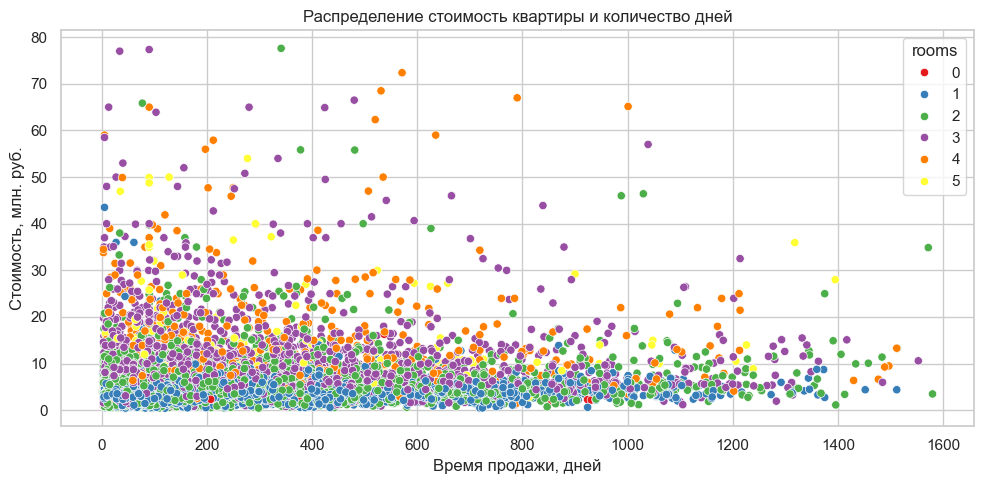

In [78]:
fig, axes = plt.subplots(figsize=(10,5))
sns.set(style = "whitegrid")
palette = sns.color_palette('Set1', 6)
tdf = df[df.days_exposition != 0]
# tdf = df.query('days_exposition != 0 and rooms==1')
sns.scatterplot(data=tdf, x='days_exposition', y='last_price_mln', hue='rooms',
               palette=palette)
plt.title('Распределение стоимость квартиры и количество дней')
plt.ylabel('Стоимость, млн. руб.')
plt.xlabel('Время продажи, дней')
plt.tight_layout()
plt.show()

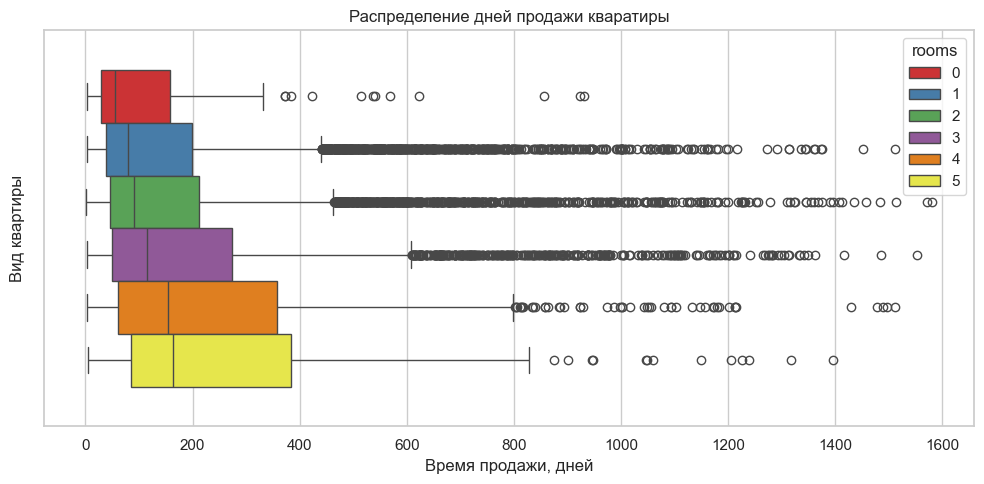

In [79]:
fig, axes = plt.subplots(figsize=(10,5))
sns.set(style = "whitegrid")
palette = sns.color_palette('Set1', 6)
tdf = df.query('days_exposition != 0') 
sns.boxplot(data=tdf, x='days_exposition', hue='rooms', palette=palette)
# sns.boxplot(data=tdf, x='last_price_mln', hue='rooms')
plt.title('Распределение дней продажи кваратиры')
plt.xlabel('Время продажи, дней')
plt.ylabel('Вид квартиры')
plt.tight_layout()
plt.show()

In [80]:
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_per_square', 'day_of_week',
       'month', 'year', 'floor_type', 'city_centers_nearest_km',
       'living_total_ratio', 'last_price_mln'],
      dtype='object')

Определим факторы, котороые больше всего влияют на стоимость объекта. Проанализируем плолщадь, количество комнат, этаж, время размещения объявления

 Корреляция цены и общей площади:

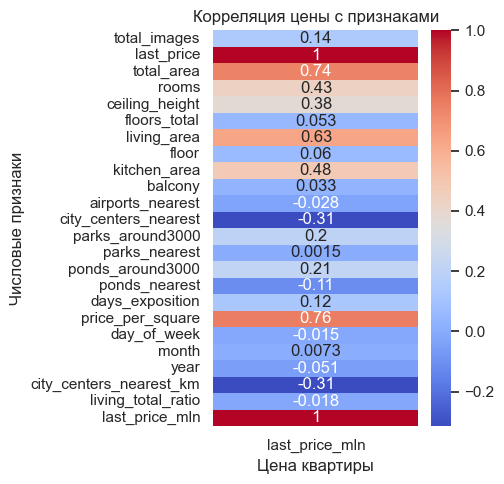

In [81]:
numeric_cols = df.select_dtypes(include='number').columns
corr = df[numeric_cols].corr()

fig, axes = plt.subplots(figsize=(5,5))
sns.set(style = "whitegrid")
palette = sns.color_palette('Set1', 6)
sns.heatmap(corr[['last_price_mln', ]], 
            annot=True, fmt='.2g', cmap= 'coolwarm')
plt.title('Корреляция цены с признаками')
plt.xlabel('Цена квартиры')
plt.ylabel('Числовые признаки')
plt.tight_layout()

Есть высокая корреляция между общей площадью и ценой. Чем больше площадь, тем больше цена недвижимости. Средняя корреляция с ценой - у жилой площади, площади кухни, стоимость квадратного метра. Слаба корреляция - с площадью кухни, количеством комнат и высотой потолка. Остальные признакинапрямую не влияют на стоимость.

In [82]:
print(corr[['last_price_mln', ]].sort_values(by='last_price_mln', ascending=False))

                              last_price_mln
last_price_mln                          1.00
last_price                              1.00
price_per_square                        0.76
total_area                              0.74
living_area                             0.63
kitchen_area                            0.48
rooms                                   0.43
ceiling_height                          0.38
ponds_around3000                        0.21
parks_around3000                        0.20
total_images                            0.14
days_exposition                         0.12
floor                                   0.06
floors_total                            0.05
balcony                                 0.03
month                                   0.01
parks_nearest                           0.00
day_of_week                            -0.01
living_total_ratio                     -0.02
airports_nearest                       -0.03
year                                   -0.05
ponds_near

Еще раз для наглядности график распределения цены по площади

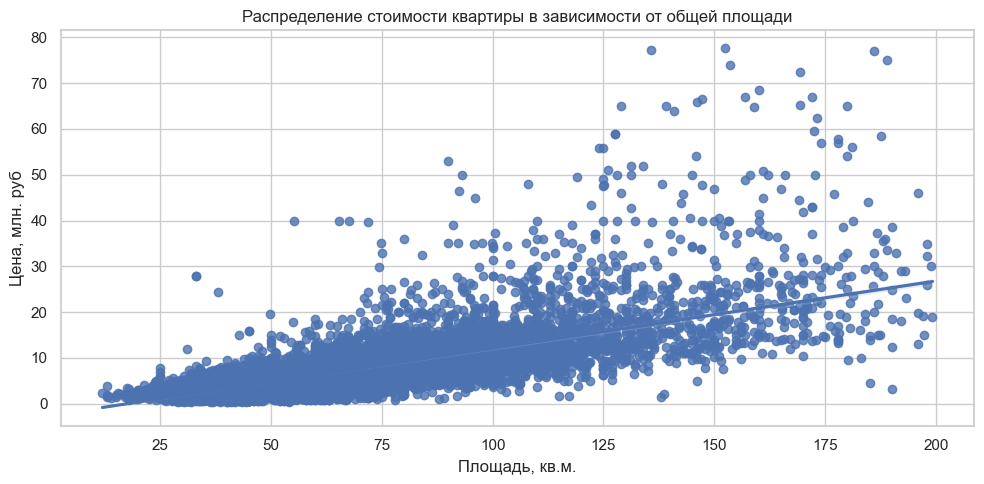

In [83]:
fig, axes = plt.subplots(figsize=(10,5))
sns.set(style = "whitegrid")
palette = sns.color_palette('Set1', 6)

sns.regplot(df, x='total_area', y='last_price_mln')

plt.title('Распределение стоимости квартиры в зависимости от общей площади')
plt.xlabel('Площадь, кв.м.')
plt.ylabel('Цена, млн. руб')
plt.tight_layout()

Как изменялась стоимость квадратного метра по годам.

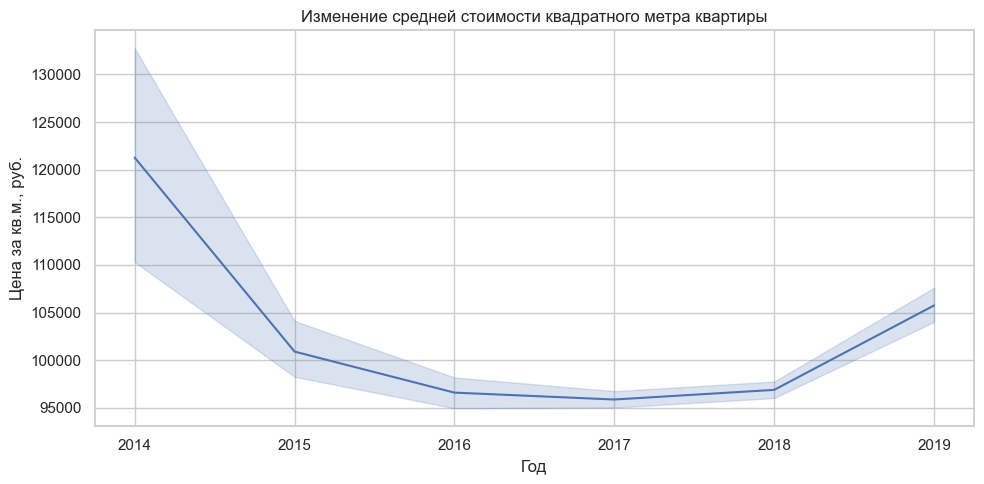

In [84]:
fig, axes = plt.subplots(figsize=(10,5))
sns.set(style = "whitegrid")
palette = sns.color_palette('Set1', 6)
tdf = df.pivot_table(index='year', values='price_per_square')
sns.lineplot(df, x='year', y='price_per_square', palette= palette)
plt.title('Изменение средней стоимости квадратного метра квартиры')
plt.xlabel('Год')
plt.ylabel('Цена за кв.м., руб.')
plt.tight_layout()
plt.show()

Видно как цены на недвтжимость в пересчете на 1 кв. м снижалисьвплоть до 2017 года. Потом виден рост. Закрашенная область указывает на разброс значений.

Изучим в какие дни недели пользователи наиболее часто публиковали объявления.

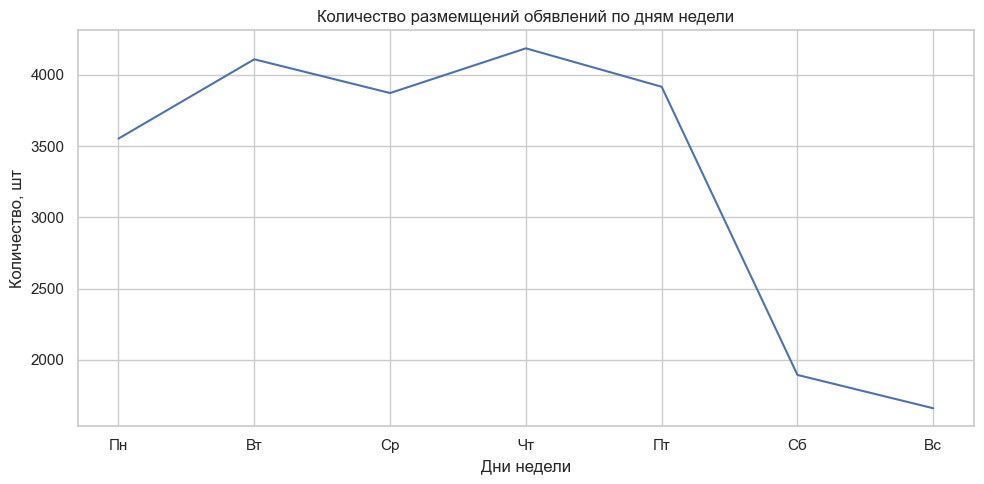

In [85]:
tdf = df.pivot_table(index='day_of_week', values='last_price_mln', aggfunc='count').reset_index()
days = {0:'Пн', 1: 'Вт', 2:'Ср', 3:'Чт', 4:'Пт', 5:'Сб', 6:'Вс'}
tdf['day'] = tdf['day_of_week'].map(days)
tdf = tdf[['day', 'last_price_mln']]
fig, axes = plt.subplots(figsize=(10,5))
sns.set(style = "whitegrid")
palette = sns.color_palette('Set1', 6)
sns.lineplot(tdf, x='day', y='last_price_mln')
plt.title('Количество размемщений обявлений по дням недели')
plt.xlabel('Дни недели')
plt.ylabel('Количество, шт')
plt.tight_layout()
plt.show()

Судя по всему, в выходные объявления размещают реже всего.

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений — построим сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов.

Средняя цена за кв.м. в 10 населенных пунктов (locality_name) с наибольшим числом объявлений.
Находим список населенных пунктов с самым большим количеством объявлений.

In [86]:
locality_max_10 = df.groupby(['locality_name'])['locality_name'].count().sort_values(ascending=False).head(10).index.tolist()
locality_max_10

['Санкт-Петербург',
 'поселок Мурино',
 'поселок Шушары',
 'Всеволожск',
 'Пушкин',
 'Колпино',
 'поселок Парголово',
 'Гатчина',
 'деревня Кудрово',
 'Выборг']

Считаем среднее значение 1 кв м в объявления по каждому населенному пункту

In [87]:

# data.query('locality_name in @locality_max_10').groupby(['locality_name']).agg({'price_per_square': ['mean']}).reset_index().sort_values(by=('price_per_square', 'mean'), ascending=False)
df_top_locality = df.query('locality_name in @locality_max_10').pivot_table(index='locality_name', values='price_per_square').reset_index().sort_values(by='price_per_square', ascending=False)
df_top_locality.reset_index(drop=True)

,locality_name,price_per_square
0,Санкт-Петербург,112953.24
1,Пушкин,103213.47
2,деревня Кудрово,92473.55
3,поселок Парголово,90332.26
4,поселок Мурино,85629.57
5,поселок Шушары,78551.34
6,Колпино,75333.30
7,Гатчина,68746.15
8,Всеволожск,68654.47
9,Выборг,58141.91


Самая высокая стоимость кв. метра жилья в Санкт-Петербурге - 112 937 руб.
Самая низкая стоимость 1 кв м - в Выборге - 58 142 р - почти в 2 раза ниже С-Петербурга

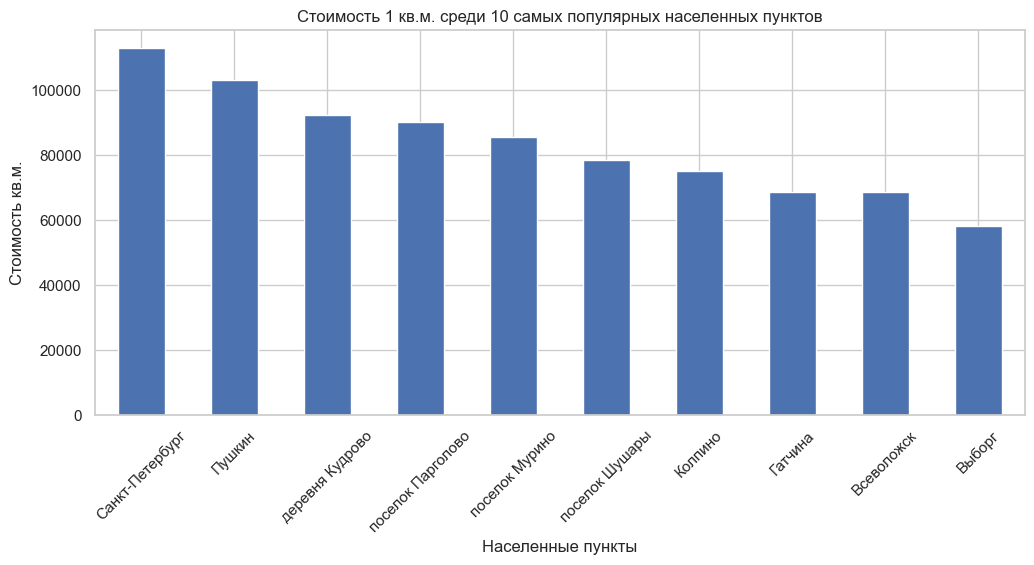

In [88]:
(df_top_locality.reset_index(drop=True).
 plot(kind='bar', figsize=(12,5), legend=False, 
      x='locality_name', rot=45,
      y='price_per_square',
      title='Стоимость 1 кв.м. среди 10 самых популярных населенных пунктов', 
      xlabel='Населенные пункты', ylabel='Стоимость кв.м.'));

Посчитаем график зависимости средней стоимости квартиры в Санкт-петербурге в зависимости от удаления от центра.

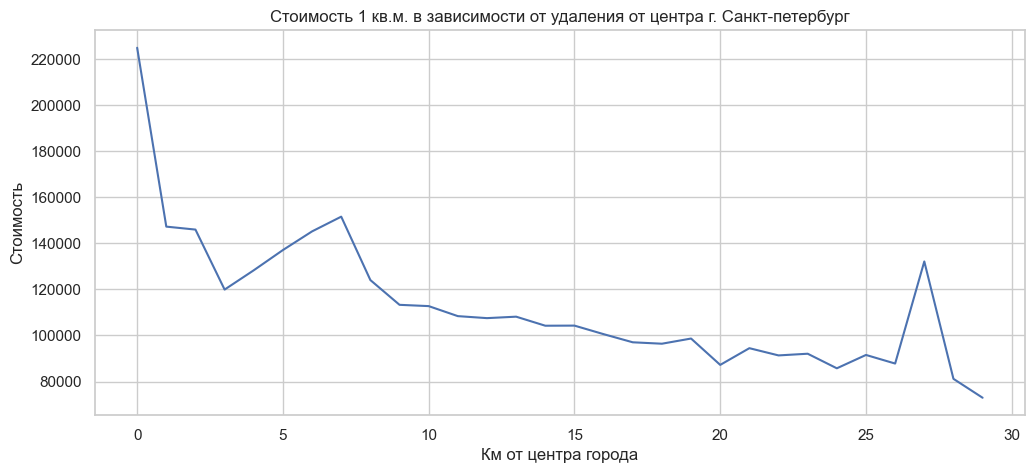

In [89]:
(df.query('locality_name == "Санкт-Петербург"').
 pivot_table(index='city_centers_nearest_km', values='price_per_square').
 plot(grid=True, xlabel='Км от центра города', ylabel='Стоимость', 
      title='Стоимость 1 кв.м. в зависимости от удаления от центра г. Санкт-петербург', 
      legend=False, figsize=(12, 5)));
plt.show();

In [90]:
df.query('(locality_name == "Санкт-Петербург") and (city_centers_nearest_km == 27)')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square,day_of_week,month,year,floor_type,city_centers_nearest_km,living_total_ratio,last_price_mln
748,13,14350000,74.00,2017-11-28,2,3.13,5,30.00,3,False,False,False,25.00,0,Санкт-Петербург,23888,27313,1,1496,0,<NA>,128,193918.92,1,11,2017,другой,27,0.41,14.35
5961,6,2250000,32.00,2018-02-27,1,2.65,2,16.50,2,False,False,False,7.00,0,Санкт-Петербург,24006,27431,0,<NA>,0,<NA>,178,70312.50,1,2,2018,последний,27,0.52,2.25


С удалением от центра города (Санкт-Петербург) стоимость 1 кв. м. падает. Со 176 т.р. в центре до 73 тыс.кв.м. на расстоянии 29 км. от центра. На расстоянии 27 км есть аномалия по оцене. Это выбросы. Можно резюмировать, что центром считаются квартиры в радицсе до 7 км от центральной точки.

## Общий вывод

**Общий вывод:**

Изначально представлены данные из 23699 объявлений недвижимости. В ходе предообработки были выявлены аномалии в данных и заполнены пропуски. Ошибки и отсутствие данных могут быть вызваны некорректной рабтой автоматического заполнения полей при вводе данных пользователями (количество балконов) и автоматическом заполнении автополей (расстояния до аэропорта, центра города, парков).
В названиях населенных пунктов исправлены ё на е.
В ходе очистки данных были убраны крайние значения характеристик объектов для исключения искажения выводов.
Больше всего объявлений о продаже квартир площадью 45 кв.м. Минимальная квартира - 12 кв.м. Максимальная после очистки данных - 199 кв.м.
Минимальная жилая площадь рава 2 кв.м. Самая распространенная жилая площадь 18 кв.м. Максимальная - 164 кв.м.
Площадь кухни самая распространенная - 6 кв.м. Минимальная 1,3 кв.м. Медианная - 9 кв.м., максимум 93 кв.м.
Самая популярная цена в объявлениях о продаже 4,5 млн. руб. За самое недорогое жилье просят 430 тыс. руб. За самое дорогое - больше 77 млн. Средняя стоимость квартиры на площадке 5,9 млн. Медианное значение - 4,6 млн.
Больше всего объявлений о продаже однушек. И по уменьшению популярности: 2, 3, 4, 5 комнатные квартиры. И студии.
Наиболее распространенная высота потолков 2,65 м. Максимум при обработке данных ограничили 5 м, минимум 2 метрами. 
Наиболее часто встречаются квартины не первых и не последних этажей, что логично.
После исключения объявлений с квартирами выше 30 этажа получили: минимальная этажность 1, максимальная - 29 этажей. Самые распространенные объявления с квартирами в - 5-этажках и 9-этажках. Таких домов больше других.
Показатель расстояния до центра города. Мода расстояния от центра города - 8,4 км. 75% объявлений о квартирах с расстоянием до центра не более 16 км. Половина всех квартир расположена в пределах расстояния от центра 9,3 до 16 км.
В среднем в объявлениях до парка около 500 метров. Чаще всего указано 441 м. Максимальное расстояние до парка в объявления более 3 км.
В среднем квартира продается за 3 месяца (95 дней). Быстрые продажи - менее 45 дней. Необычно долгие продажи - более 229 дней. Максимальное размещение в выборке - 1580 дней.
Есть прямая корреляция между общей площадью и ценой. Чем больше площадь, тем больше цена недвижимости. Разницы в графиках по среднему или медиане нет.
Есть прямая зависимость цены от жилой площади.
Есть прямая зависимость цены от площади кухни.
Зависимость цены от числа комнат очевидна, коррелирует.
У квартир не на первом и не на последнем этаже цена выше.
Самые дорогие квартиры выкладывают во вторник. 
В марте начинается рост цен на квартиры. Самый "дорогой месяц" - апрель, спад цен - в июне. 
График по годам показывает, что объявления с самой высокой ценой за квартиры подавались в 2014 году, потом идет спад. Рост начинается в 2018-2019 годах.
Самая высокая стоимость кв. метра жилья в Санкт-Петербурге - 112 937 руб. Самая низкая стоимость 1 кв м - в Выборге - 58 142 р - почти в 2 раза ниже С-Петербурга.
С удалением от центра города (Санкт-Петербург) стоимость 1 кв. м. падает. Со 176 т.р. в центре до 73 тыс.кв.м. на расстоянии 29 км. от центра.